In [1]:
import os
import sys
main_directory = os.getcwd()
parent_directory = os.path.dirname(main_directory)
parent_directory = os.path.dirname(parent_directory)
# Define the subdirectories you want to add to sys.path
subdirs = ['MaRGE', 'marcos_client']

# Add the subdirectories to sys.path
for subdir in subdirs:
    full_path = os.path.join(parent_directory, subdir)
    print(full_path)
    sys.path.append(full_path)

import numpy as np
import matplotlib.pyplot as plt
import experiment as ex
from local_config import grad_board
import seq.mriBlankSeq as blankSeq  # Import the mriBlankSequence for any new sequence.
import configs.hw_config as hw
import configs.units as units
import time
import warnings
warnings.filterwarnings("ignore")


import pdb
st = pdb.set_trace

/Users/raphaetrinkler/Documents/_bakk/Console/MaRGE
/Users/raphaetrinkler/Documents/_bakk/Console/marcos_client


In [2]:
class TSE(blankSeq.MRIBLANKSEQ):
    def __init__(self):
        super(TSE, self).__init__()

        self.addParameter(key='seqName', string='TSEInfo', val='TSE')

        self.addParameter(key='nScans', string='Number of scans', val=1, field='SEQ') # trs

        self.addParameter(key='larmorFreq', string='Larmor frequency (MHz)', val=16.5, units=units.MHz, field='RF') # lo_freq
        
        self.addParameter(key='rfExAmp', string='RF excitation amplitude (a.u.)', val=0.3, field='RF') # rf_amp excitation

        self.addParameter(key='rfReAmp', string='RF refocusing amplitude (a.u.)', val=0.3, field='RF') #rf_amp refocusing

        self.addParameter(key='rfExTime', string='RF excitation time (us)', val=30.0, units=units.us, field='RF') # rf_pi2_duration (pi/2 = 90 degree flip angle) -> Excitation

        self.addParameter(key='rfReTime', string='RF refocusing time (us)', val=60.0, units=units.us, field='RF') # 2*rf_pi2_duration = rf_pi_duration = pi = 180 degree flip angle -> refocusing

        self.addParameter(key='echoSpacing', string='Echo spacing (ms)', val=10.0, units=units.ms, field='SEQ') # echo_duration

        self.addParameter(key='repetitionTime', string='Repetition time (ms)', val=3000, units=units.ms, field='SEQ') # tr_pause_duration + echo_duration*echos_per_tr

        self.addParameter(key='nPoints', string='Number of acquired points', val=60, field='IM') # non_existent

        self.addParameter(key='fov', string='FOV (cm)', val=[4.0, 4.0, 4.0], field='IM')
        
        self.addParameter(key='dfov', string='dFOV (mm)', val=[0.0, 0.0, 0.0], field='IM')

        self.addParameter(key='etl', string='Echo train length', val=5, field='SEQ') # echos_per_tr
        self.addParameter(key='acqTime', string='Acquisition time (ms)', val=2.0, units=units.ms, field='SEQ') # readout_duration
        self.addParameter(key='shimming', string='shimming', val=[0.0, 0.0, 0.0], units=units.sh, field='OTH') # Shimming (non existent)


    def sequenceInfo(self):
        
        print("TSE")
        print("Author: Raphael Trinkler")
        print("Contact: raphael.trinkler@student.tugraz.at")
        print("This sequence runs a Turbo Spin Echo")

    def sequenceTime(self):
        nScans = self.mapVals['nScans']
        repetitionTime = self.mapVals['repetitionTime']*1e-3
        return(repetitionTime*nScans/60)  # minutes, scanTime
    

    def sequenceRun(self, plotSeq=0, demo=False):
        """Generates the TSE sequence."""
        # Create sequence instructions
        
        # Input instructions into the Red Pitaya
        
        # Use the plotSeq argument to control plotting versus running.
        
        # Use the demo argument to control if you want to simulate signals.

        self.demo = demo


        etl = self.mapVals['etl']
        echo_spacing = self.mapVals['echoSpacing'] * 1e-3  # Convert to seconds
        rf_ex_time = self.mapVals['rfExTime'] * 1e-6  # Convert to seconds
        rf_re_time = self.mapVals['rfReTime'] * 1e-6  # Convert to seconds

        sequence_blocks = []

        # Initial excitation pulse
        rf_excitation = {
            'type': 'rf',
            'duration': rf_ex_time,
            'amplitude': self.mapVals['rfExAmp']
        }
        sequence_blocks.append(rf_excitation)

        # Refocusing pulses and echoes
        for echo in range(etl):
            rf_refocusing = {
                'type': 'rf',
                'duration': rf_re_time,
                'amplitude': self.mapVals['rfReAmp']
            }
            gradient_rephasing = {
                'type': 'gradient',
                'axis': 'z',
                'amplitude': 0.5,  # Example amplitude
                'duration': echo_spacing / 2 - rf_re_time
            }
            
            readout = {
                'type': 'adc',
                'duration': self.mapVals['acqTime'] * 1e-3  # Convert to seconds
            }

            # Append blocks for the echo
            sequence_blocks.extend([rf_refocusing, gradient_rephasing, readout])

        self.sequence_blocks = sequence_blocks

        print(f"TSE sequence with {etl} echoes generated.")
        return self.sequence_blocks


    def sequenceAnalysis(self, mode=None):
        self.mode = mode
        axesEnable = self.mapVals['axesEnable']
        # Get axes in strings
        axes_dict = {'x': 0, 'y': 1, 'z': 2}
        axes_keys = list(axes_dict.keys())
        axes_vals = list(axes_dict.values())
        axes_str = ['', '', '']
        n = 0
        for val in self.axesOrientation:
            index = axes_vals.index(val)
            axes_str[n] = axes_keys[index]
            n += 1

        if (axesEnable[1] == 0 and axesEnable[2] == 0):
            bw = self.mapVals['bw']*1e-3 # kHz
            t_vector = np.linspace(-self.acq_time/2, self.acq_time/2, self.nPoints[0])*1e-3 # ms
            s_vector = self.mapVals['sampled'][:, 3]
            f_vector = np.linspace(-bw/2, bw/2, self.nPoints[0])
            i_vector = np.fft.ifftshift(np.fft.ifftn(np.fft.ifftshift(s_vector)))
            result1 = {'widget': 'curve',
                       'xData': t_vector,
                       'yData': [np.abs(s_vector), np.real(s_vector), np.imag(s_vector)],
                       'xLabel': 'Time (ms)',
                       'yLabel': "Signal amplitude (mV)",
                       'title': "Signal",
                       'legend': ['Magnitude', 'Real', 'Imaginary'],
                       'row': 0,
                       'col': 0}

            result2 = {'widget': 'curve',
                       'xData': f_vector,
                       'yData': [np.abs(i_vector)],
                       'xLabel': "Frequency (kHz)",
                       'yLabel': "Amplitude (a.u.)",
                       'title': "Spectrum",
                       'legend': ['Spectrum magnitude'],
                       'row': 1,
                       'col': 0}

            self.output = [result1, result2]

        else:
            # Plot image
            image = np.abs(self.mapVals['image3D'])
            image = image / np.max(np.reshape(image, -1)) * 100

            if not self.unlock_orientation:  # Image orientation
                if self.axesOrientation[2] == 2:  # Sagittal
                    title = "Sagittal"
                    if self.axesOrientation[0] == 0 and self.axesOrientation[1] == 1:  # OK
                        image = np.flip(image, axis=2)
                        image = np.flip(image, axis=1)
                        xLabel = "(-Y) A | PHASE | P (+Y)"
                        yLabel = "(-X) I | READOUT | S (+X)"
                    else:
                        image = np.transpose(image, (0, 2, 1))
                        image = np.flip(image, axis=2)
                        image = np.flip(image, axis=1)
                        xLabel = "(-Y) A | READOUT | P (+Y)"
                        yLabel = "(-X) I | PHASE | S (+X)"
                elif self.axesOrientation[2] == 1:  # Coronal
                    title = "Coronal"
                    if self.axesOrientation[0] == 0 and self.axesOrientation[1] == 2:  # OK
                        image = np.flip(image, axis=2)
                        image = np.flip(image, axis=1)
                        image = np.flip(image, axis=0)
                        xLabel = "(+Z) R | PHASE | L (-Z)"
                        yLabel = "(-X) I | READOUT | S (+X)"
                    else:
                        image = np.transpose(image, (0, 2, 1))
                        image = np.flip(image, axis=2)
                        image = np.flip(image, axis=1)
                        image = np.flip(image, axis=0)
                        xLabel = "(+Z) R | READOUT | L (-Z)"
                        yLabel = "(-X) I | PHASE | S (+X)"
                elif self.axesOrientation[2] == 0:  # Transversal
                    title = "Transversal"
                    if self.axesOrientation[0] == 1 and self.axesOrientation[1] == 2:
                        image = np.flip(image, axis=2)
                        image = np.flip(image, axis=1)
                        xLabel = "(+Z) R | PHASE | L (-Z)"
                        yLabel = "(+Y) P | READOUT | A (-Y)"
                    else:  # OK
                        image = np.transpose(image, (0, 2, 1))
                        image = np.flip(image, axis=2)
                        image = np.flip(image, axis=1)
                        xLabel = "(+Z) R | READOUT | L (-Z)"
                        yLabel = "(+Y) P | PHASE | A (-Y)"
            else:
                xLabel = "%s axis" % axesStr[1]
                yLabel = "%s axis" % axesStr[0]
                title = "Image"

            result1 = {}
            result1['widget'] = 'image'
            result1['data'] = image
            result1['xLabel'] = xLabel
            result1['yLabel'] = yLabel
            result1['title'] = title
            result1['row'] = 0
            result1['col'] = 0

            result2 = {}
            result2['widget'] = 'image'
            if self.sl_fraction == 1:
                result2['data'] = np.log10(np.abs(self.mapVals['kSpace3D']))
            else:
                result2['data'] = np.abs(self.mapVals['kSpace3D'])
            result2['xLabel'] = "k%s" % axes_str[1]
            result2['yLabel'] = "k%s" % axes_str[0]
            result2['title'] = "k-Space"
            result2['row'] = 0
            result2['col'] = 1

            # Reset rotation angle and dfov to zero
            self.mapVals['angle'] = 0.0
            self.mapVals['dfov'] = [0.0, 0.0, 0.0]
            hw.dfov = [0.0, 0.0, 0.0]

            # DICOM TAGS
            # Image
            imageDICOM = np.transpose(image, (0, 2, 1))
            # If it is a 3d image
            if len(imageDICOM.shape) > 2:
                # Obtener dimensiones
                slices, rows, columns = imageDICOM.shape
                self.meta_data["Columns"] = columns
                self.meta_data["Rows"] = rows
                self.meta_data["NumberOfSlices"] = slices
                self.meta_data["NumberOfFrames"] = slices
            # if it is a 2d image
            else:
                # Obtener dimensiones
                rows, columns = imageDICOM.shape
                self.meta_data["Columns"] = columns
                self.meta_data["Rows"] = rows
                self.meta_data["NumberOfSlices"] = 1
                self.meta_data["NumberOfFrames"] = 1
            imgAbs = np.abs(imageDICOM)
            imgFullAbs = np.abs(imageDICOM) * (2 ** 15 - 1) / np.amax(np.abs(imageDICOM))
            x2 = np.amax(np.abs(imageDICOM))
            imgFullInt = np.int16(np.abs(imgFullAbs))
            imgFullInt = np.reshape(imgFullInt, (slices, rows, columns))
            arr = np.zeros((slices, rows, columns), dtype=np.int16)
            arr = imgFullInt
            self.meta_data["PixelData"] = arr.tobytes()
            self.meta_data["WindowWidth"] = 26373
            self.meta_data["WindowCenter"] = 13194
            # Sequence parameters
            self.meta_data["RepetitionTime"] = self.mapVals['repetition_time']
            self.meta_data["EchoTime"] = self.mapVals['echo_time']

            # Add results into the output attribute (result1 must be the image to save in dicom)
            self.output = [result1, result2]

        # Save results
        self.saveRawData()
        self.save_ismrmrd()

        if self.mode == 'Standalone':
            self.plotResults()
            
        return self.output
        
        
        # Implement data analysis logic here

In [13]:
import matplotlib.pyplot as plt

def plot_seq(flodict):
    plt.figure(figsize=(12, 8))
    
    for key, (times, amplitudes) in flodict.items():
        plt.plot(times, amplitudes, label=key)
    
    plt.xlabel('Time (us)')
    plt.ylabel('Amplitude')
    plt.title('TSE Sequence Waveforms')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def trapezoid(plateau_a, total_t, ramp_t, ramp_pts, total_t_end_to_end=True, base_a=0):
    """Helper function that just generates a Numpy array starting at time
    0 and ramping down at time total_t, containing a trapezoid going from a
    level base_a to plateau_a, with a rising ramp of duration ramp_t and
    sampling period ramp_ts."""

    # ramp_pts = int( np.ceil(ramp_t/ramp_ts) ) + 1
    rise_ramp_times = np.linspace(0, ramp_t, ramp_pts)
    rise_ramp = np.linspace(base_a, plateau_a, ramp_pts)

    # [1: ] because the first element of descent will be repeated
    descent_t = total_t - ramp_t if total_t_end_to_end else total_t
    t = np.hstack([rise_ramp_times, rise_ramp_times[:-1] + descent_t])
    a = np.hstack([rise_ramp, np.flip(rise_ramp)[1:]])
    return t, a

def trap_cent(centre_t, plateau_a, trap_t, ramp_t, ramp_pts, base_a=0):
    """Like trapezoid, except it generates a trapezoid shape around a centre
    time, with a well-defined area given by its amplitude (plateau_a)
    times its time (trap_t), which is defined from the start of the
    ramp-up to the start of the ramp-down, or (equivalently) from the
    centre of the ramp-up to the centre of the ramp-down. All other
    parameters are as for trapezoid()."""
    t, a = trapezoid(plateau_a, trap_t, ramp_t, ramp_pts, False, base_a)
    return t + centre_t - (trap_t + ramp_t)/2, a

In [ ]:
def turbo_spin_echo(plot_rx=False, init_gpa=False, plot_sequence=False,
                    dbg_sc=0.5, # set to 0 to avoid RF debugging pulses in each RX window, otherwise amp between 0 or 1
                    lo_freq=0.2, # MHz
                    rf_amp=1, # 1 = full-scale

                    rf_pi2_duration=50, # us, rf pi/2 pulse length
                    rf_pi_duration=None, # us, rf pi pulse length  - if None then automatically gets set to 2 * rf_pi2_duration

                    # trapezoid properties - shared between all gradients for now
                    trap_ramp_duration=50, # us, ramp-up/down time
                    trap_ramp_pts=5, # how many points to subdivide ramp into

                    # spin-echo properties
                    echos_per_tr=5, # number of spin echoes (180 pulses followed by readouts) to do
                    echo_duration=2000, # us, time from the centre of one echo to centre of the next

                    readout_amp=0.8, # 1 = gradient full-scale
                    readout_duration=500, # us, time in the centre of an echo when the readout occurs
                    rx_period=10/3, # us, 3.333us, 300 kHz rate
                    readout_grad_duration=700, # us, readout trapezoid lengths (mid-ramp-up to mid-ramp-down)
                    # (must at least be longer than readout_duration + trap_ramp_duration)

                    phase_start_amp=0.6, # 1 = gradient full-scale, starting amplitude (by default ramps from +ve to -ve in each echo)
                    phase_grad_duration=150, # us, phase trapezoid lengths (mid-ramp-up to mid-ramp-down)
                    phase_grad_interval=1200, # us, interval between first phase trapezoid and its negative-sign counterpart within a single echo

                    # slice trapezoid timing is the same as phase timing
                    slice_start_amp=0.3, # 1 = gradient full-scale, starting amplitude (by default ramps from +ve to -ve in each TR)

                    tr_pause_duration=3000, # us, length of time to pause from the end of final echo's RX pulse to start of next TR
                    trs=5 # number of TRs
                    ):
    """
    readout gradient: x
    phase gradient: y
    slice/partition gradient: z
    """

    seqs=[]

    if rf_pi_duration is None:
        rf_pi_duration = 2 * rf_pi2_duration

    phase_amps = np.linspace(phase_start_amp, -phase_start_amp, echos_per_tr)
    slice_amps = np.linspace(slice_start_amp, -slice_start_amp, trs)

    # create appropriate waveforms for each echo, based on start time, echo index and TR index
    # note: echo index is 0 for the first interval (90 pulse until first 180 pulse) thereafter 1, 2 etc between each 180 pulse
    def rf_wf(tstart, echo_idx):
        pi2_phase = 1 # x
        pi_phase = 1j # y
        if echo_idx == 0:
            # do pi/2 pulse, then start first pi pulse
            return np.array([tstart + (echo_duration - rf_pi2_duration)/2, tstart + (echo_duration + rf_pi2_duration)/2,
                             tstart + echo_duration - rf_pi_duration/2]), np.array([pi2_phase, 0, pi_phase]) * rf_amp
        elif echo_idx == echos_per_tr:
            # finish final RF pulse
            return np.array([tstart + rf_pi_duration/2]), np.array([0])
        else:
            # finish last pi pulse, start next pi pulse
            return np.array([tstart + rf_pi_duration/2, tstart + echo_duration - rf_pi_duration/2]), np.array([0, pi_phase]) * rf_amp

    def tx_gate_wf(tstart, echo_idx):
        tx_gate_pre = 2 # us, time to start the TX gate before each RF pulse begins
        tx_gate_post = 1 # us, time to keep the TX gate on after an RF pulse ends

        if echo_idx == 0:
            # do pi/2 pulse, then start first pi pulse
            return np.array([tstart + (echo_duration - rf_pi2_duration)/2 - tx_gate_pre,
                             tstart + (echo_duration + rf_pi2_duration)/2 + tx_gate_post,
                             tstart + echo_duration - rf_pi_duration/2 - tx_gate_pre]), \
                             np.array([1, 0, 1])
        elif echo_idx == echos_per_tr:
            # finish final RF pulse
            return np.array([tstart + rf_pi_duration/2 + tx_gate_post]), np.array([0])
        else:
            # finish last pi pulse, start next pi pulse
            return np.array([tstart + rf_pi_duration/2 + tx_gate_post, tstart + echo_duration - rf_pi_duration/2 - tx_gate_pre]), \
                np.array([0, 1])

    def readout_grad_wf(tstart, echo_idx):
        if echo_idx == 0:
            return trap_cent(tstart + echo_duration*3/4, readout_amp, readout_grad_duration/2,
                             trap_ramp_duration, trap_ramp_pts)
        else:
            return trap_cent(tstart + echo_duration/2, readout_amp, readout_grad_duration,
                             trap_ramp_duration, trap_ramp_pts)

    def readout_wf(tstart, echo_idx):
        if echo_idx != 0:
            return np.array([tstart + (echo_duration - readout_duration)/2, tstart + (echo_duration + readout_duration)/2 ]), np.array([1, 0])
        else:
            return np.array([tstart]), np.array([0]) # keep on zero otherwise

    def phase_grad_wf(tstart, echo_idx):
        t1, a1 = trap_cent(tstart + (echo_duration - phase_grad_interval)/2, phase_amps[echo_idx-1], phase_grad_duration,
                           trap_ramp_duration, trap_ramp_pts)
        t2, a2 = trap_cent(tstart + (echo_duration + phase_grad_interval)/2, -phase_amps[echo_idx-1], phase_grad_duration,
                           trap_ramp_duration, trap_ramp_pts)
        if echo_idx == 0:
            return np.array([tstart]), np.array([0]) # keep on zero otherwise
        elif echo_idx == echos_per_tr: # last echo, don't need 2nd trapezoids
            return t1, a1
        else: # otherwise do both trapezoids
            return np.hstack([t1, t2]), np.hstack([a1, a2])

    def slice_grad_wf(tstart, echo_idx, tr_idx):
        t1, a1 = trap_cent(tstart + (echo_duration - phase_grad_interval)/2, slice_amps[tr_idx], phase_grad_duration,
                           trap_ramp_duration, trap_ramp_pts)
        t2, a2 = trap_cent(tstart + (echo_duration + phase_grad_interval)/2, -slice_amps[tr_idx], phase_grad_duration,
                           trap_ramp_duration, trap_ramp_pts)
        if echo_idx == 0:
            return np.array([tstart]), np.array([0]) # keep on zero otherwise
        elif echo_idx == echos_per_tr: # last echo, don't need 2nd trapezoids
            return t1, a1
        else: # otherwise do both trapezoids
            return np.hstack([t1, t2]), np.hstack([a1, a2])

    tr_total_time = echo_duration * (echos_per_tr + 1) + tr_pause_duration

    # expt = ex.Experiment(lo_freq=lo_freq, rx_t=rx_period, init_gpa=init_gpa, gpa_fhdo_offset_time=(1 / 0.2 / 3.1)) 

    # gpa_fhdo_offset_time in microseconds; offset between channels to
    # avoid parallel updates (default update rate is 0.2 Msps, so
    # 1/0.2 = 5us, 5 / 3.1 gives the offset between channels; extra
    # 0.1 for a safety margin))

    global_t = 0 # start the first TR at this time
    plot_flodict = True
    for tr in range(trs):
        for echo in range(echos_per_tr + 1):
            tx_t, tx_a = rf_wf(global_t, echo)
            tx_gate_t, tx_gate_a = tx_gate_wf(global_t, echo)
            readout_t, readout_a = readout_wf(global_t, echo)
            rx_gate_t, rx_gate_a = readout_wf(global_t, echo)

            readout_grad_t, readout_grad_a = readout_grad_wf(global_t, echo)
            phase_grad_t, phase_grad_a = phase_grad_wf(global_t, echo)
            slice_grad_t, slice_grad_a = slice_grad_wf(global_t, echo, tr)

            global_t += echo_duration

            # expt.add_flodict(
            flodict = {
                'tx0': (tx_t, tx_a), 
                'tx1': (tx_t, tx_a),
                'grad_vx': (readout_grad_t, readout_grad_a),
                'grad_vy': (phase_grad_t, phase_grad_a),
                'grad_vz': (slice_grad_t, slice_grad_a),
                'rx0_en': (readout_t, readout_a),
                'rx1_en': (readout_t, readout_a),
                'tx_gate': (tx_gate_t, tx_gate_a),
                'rx_gate': (rx_gate_t, rx_gate_a),
            }
            # )
            seqs.append(flodict)

            if plot_flodict:
                plt.figure(figsize=(12, 6))
                colors = plt.cm.tab10(np.linspace(0, 1, len(flodict)))  

                for (key, (times, amplitudes)), color in zip(flodict.items(), colors):
                    stem = plt.stem(times, amplitudes, label=key, markerfmt='o', basefmt=" ")
                    
                    plt.setp(stem.markerline, color=color)  
                    plt.setp(stem.stemlines, color=color)  
                    
                plt.title("Combined Stem Plot of Signals")
                plt.xlabel("Time")
                plt.ylabel("Amplitude")
                plt.legend(loc='upper right', fontsize='small')
                plt.grid(True)
                plt.tight_layout()
                
                plt.show()        
            
            global_t += tr_pause_duration

    timing_vectors = {}
    amplitude_vectors = {}
    
    for flodict in seqs:
        for key, (times, amplitudes) in flodict.items():
            if key not in timing_vectors:
                timing_vectors[key] = []
                amplitude_vectors[key] = []
            timing_vectors[key].append(times)
            amplitude_vectors[key].append(amplitudes)

    timing_vectors = {key: np.concatenate(arrays) for key, arrays in timing_vectors.items()}
    amplitude_vectors = {key: np.concatenate(arrays) for key, arrays in amplitude_vectors.items()}

    for key in timing_vectors:
        plt.figure(figsize=(10, 6))
        plt.stem(
            timing_vectors[key], 
            amplitude_vectors[key], 
            markerfmt='o', 
            basefmt=" "
                )
        plt.title(f"Stem Plot for {key}")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        
    # if plot_sequence:
    #     expt.plot_sequence()
    #     plt.show()
# Example call at the end of the main function

    # rxd, msgs = expt.run()
    # expt.close_server(True)
    # expt._s.close() # close socket

    # if plot_rx:
    #     plt.plot( rxd['rx0'].real )
    #     plt.plot( rxd['rx0'].imag )
    #     plt.plot( rxd['rx1'].real )
    #     plt.plot( rxd['rx1'].imag )
    #     plt.show()

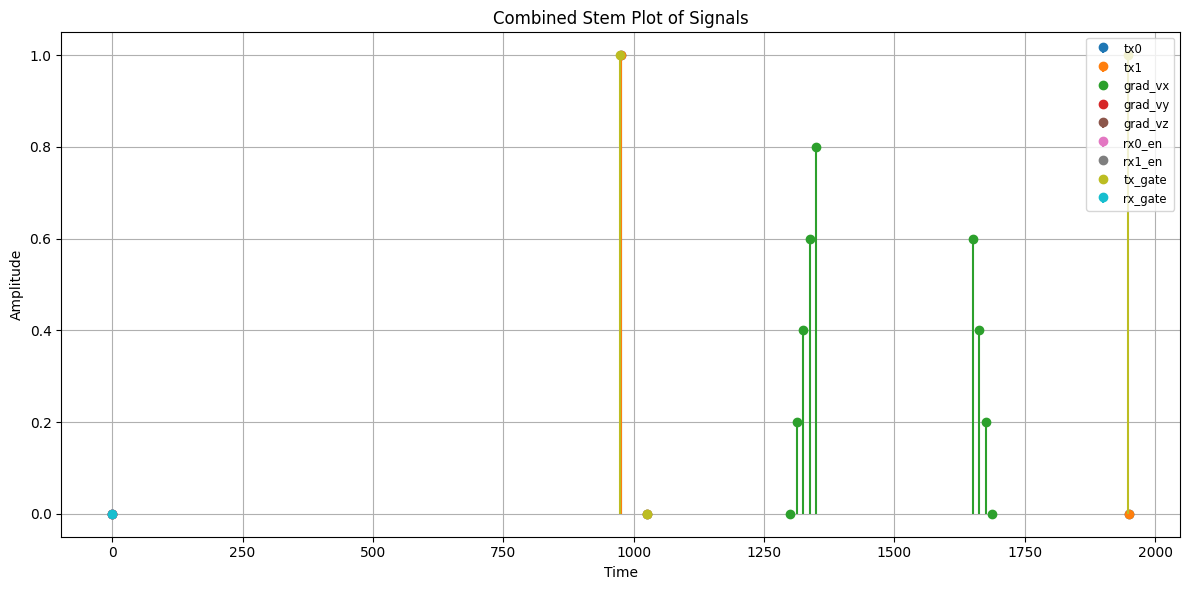

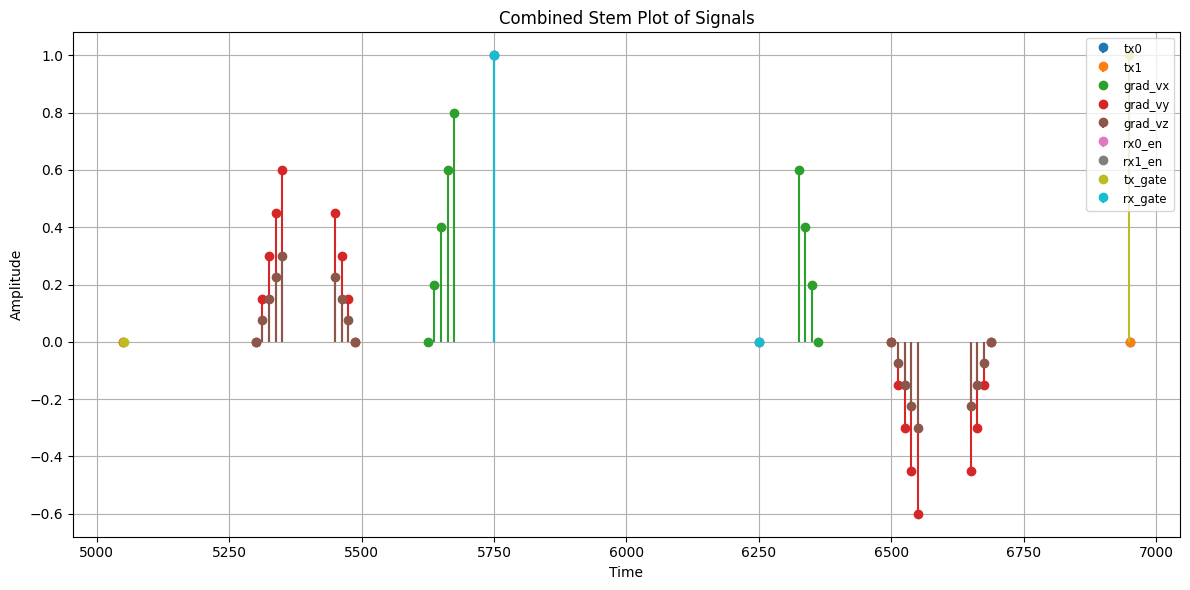

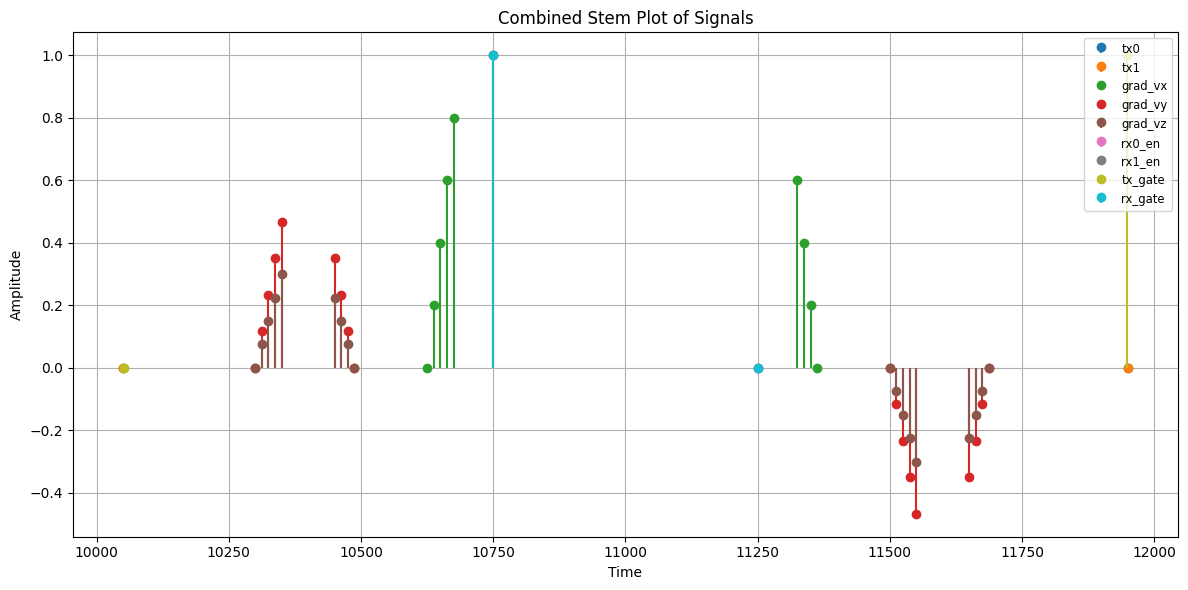

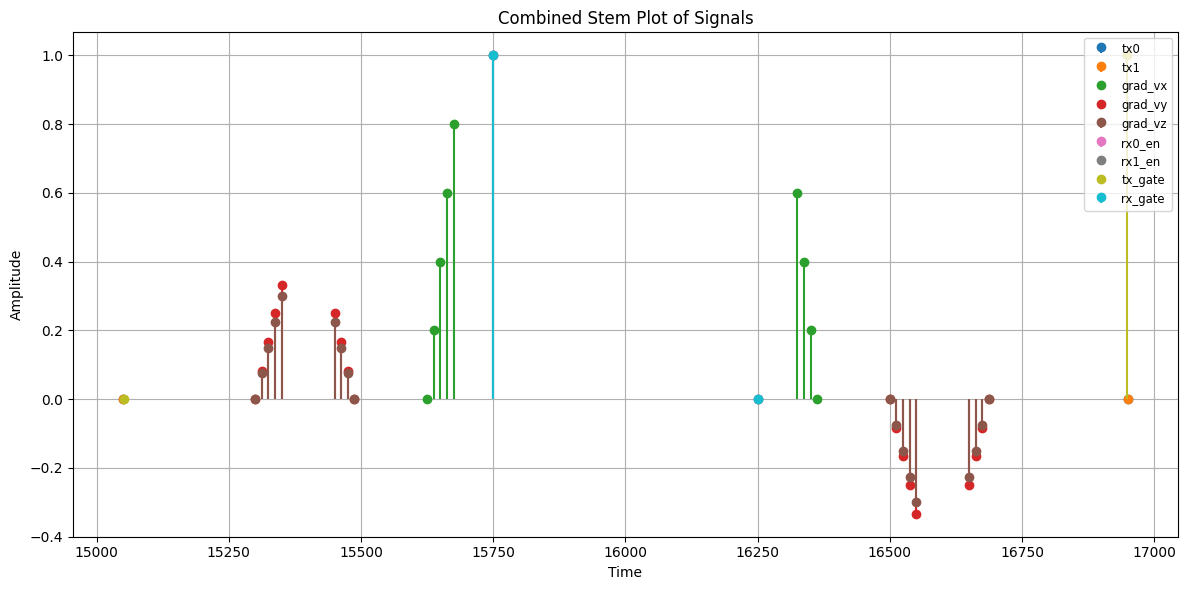

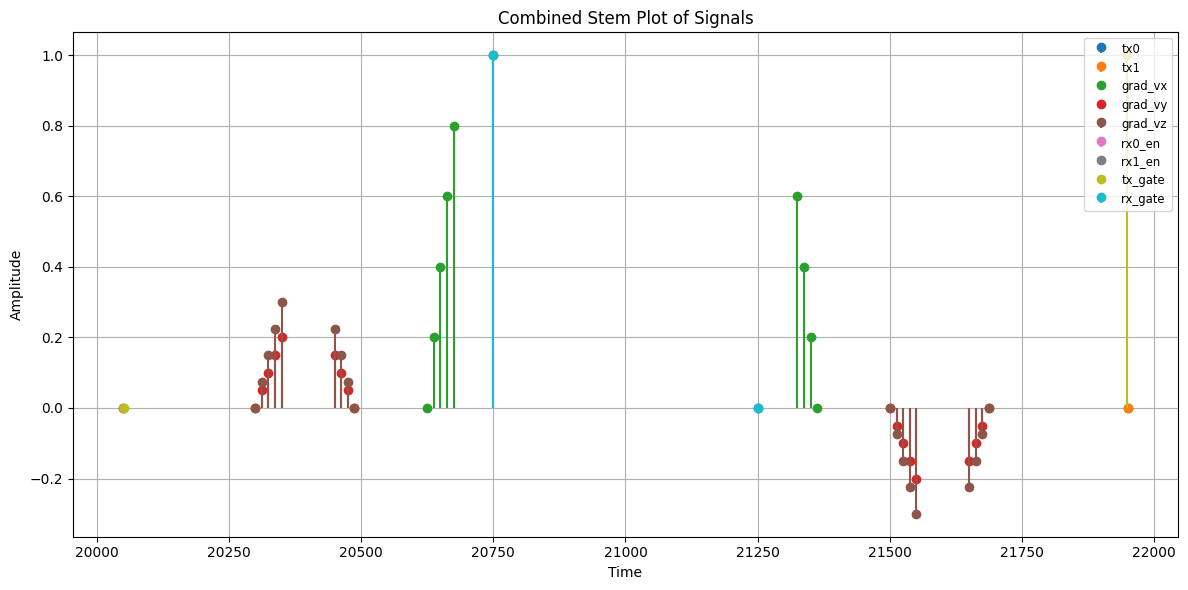

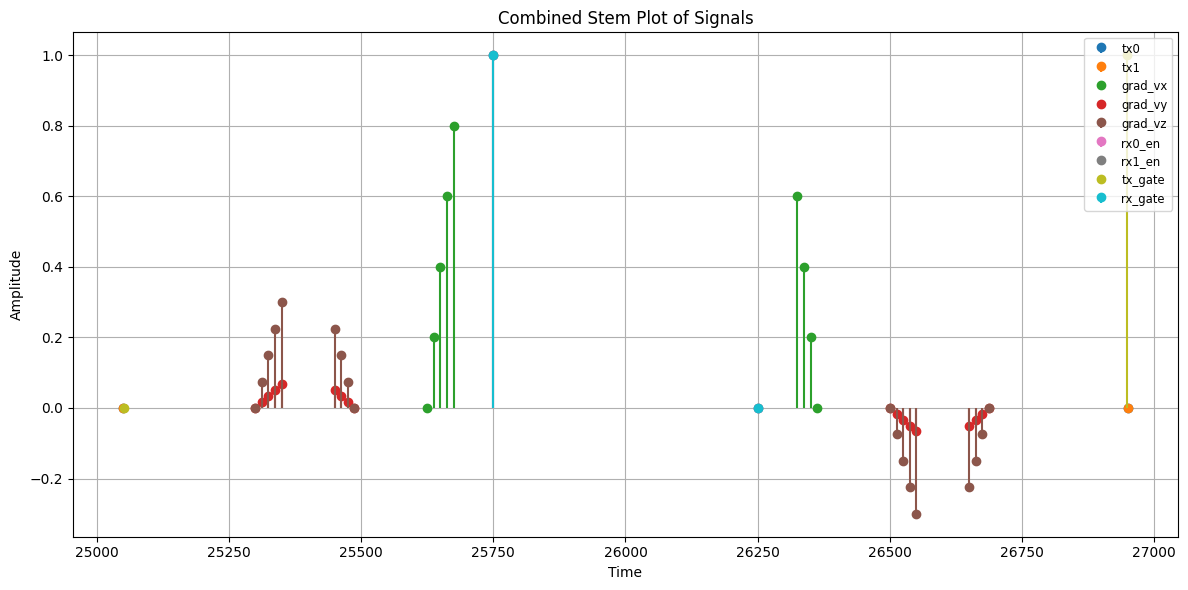

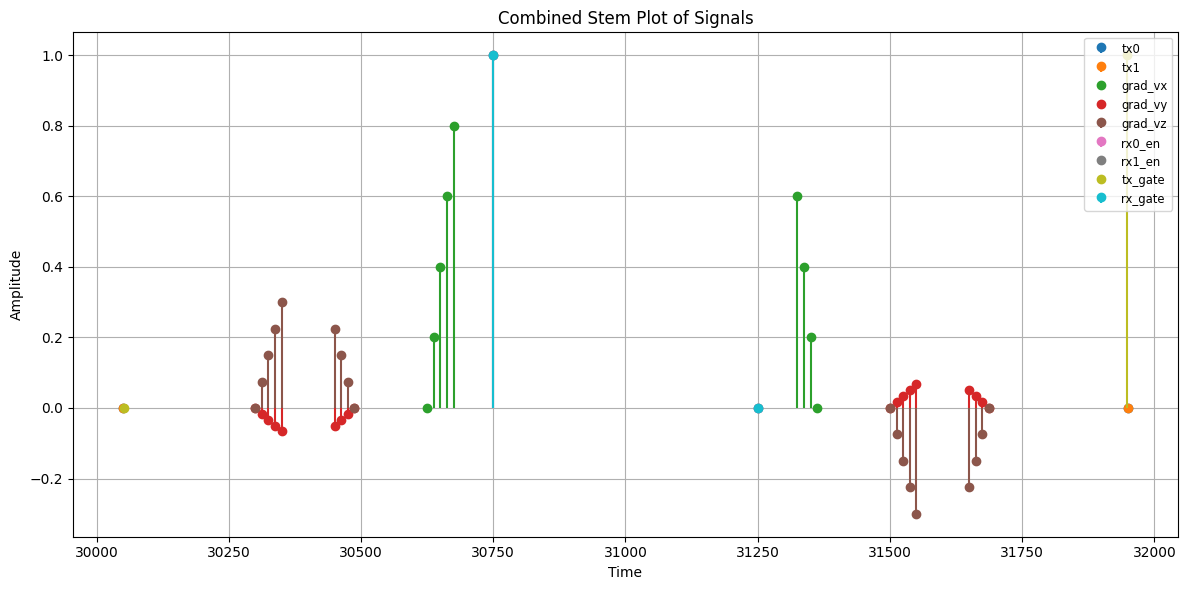

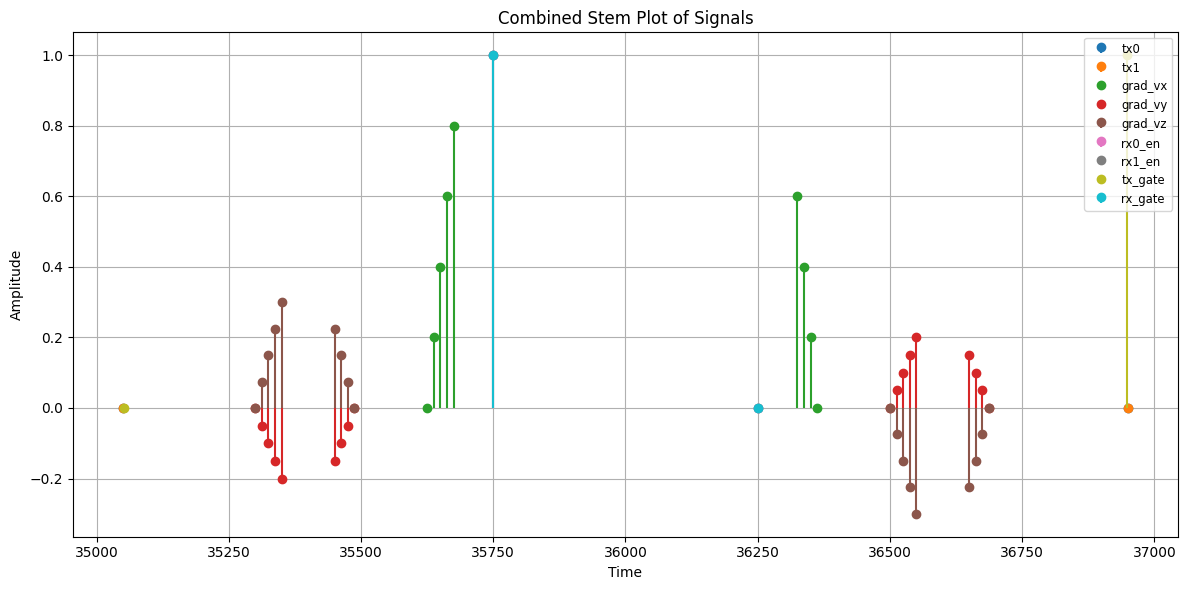

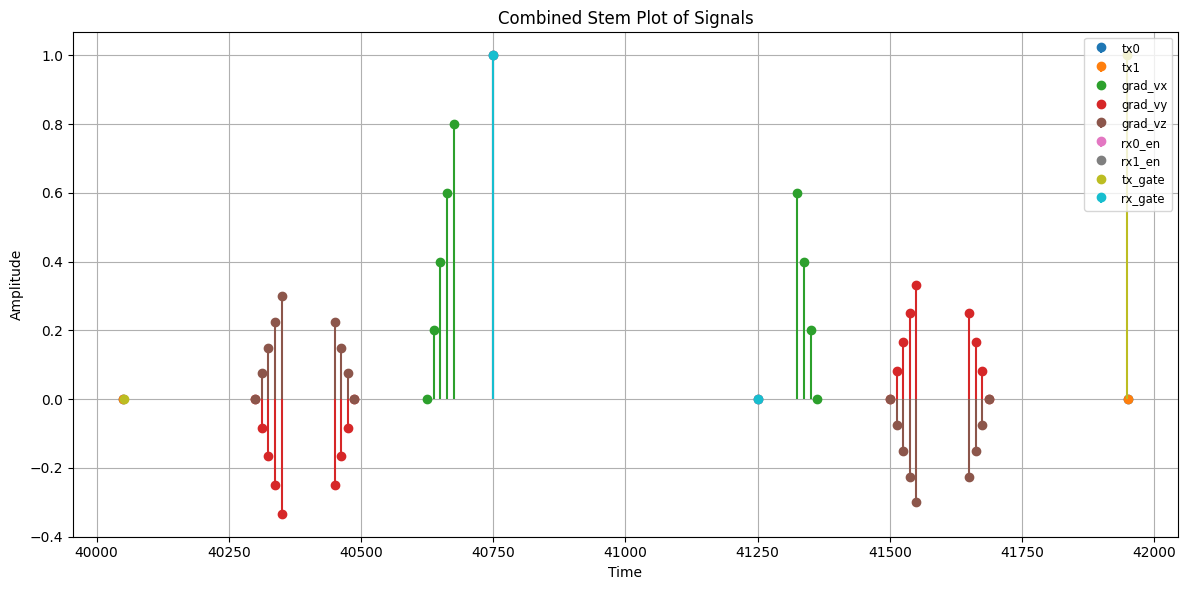

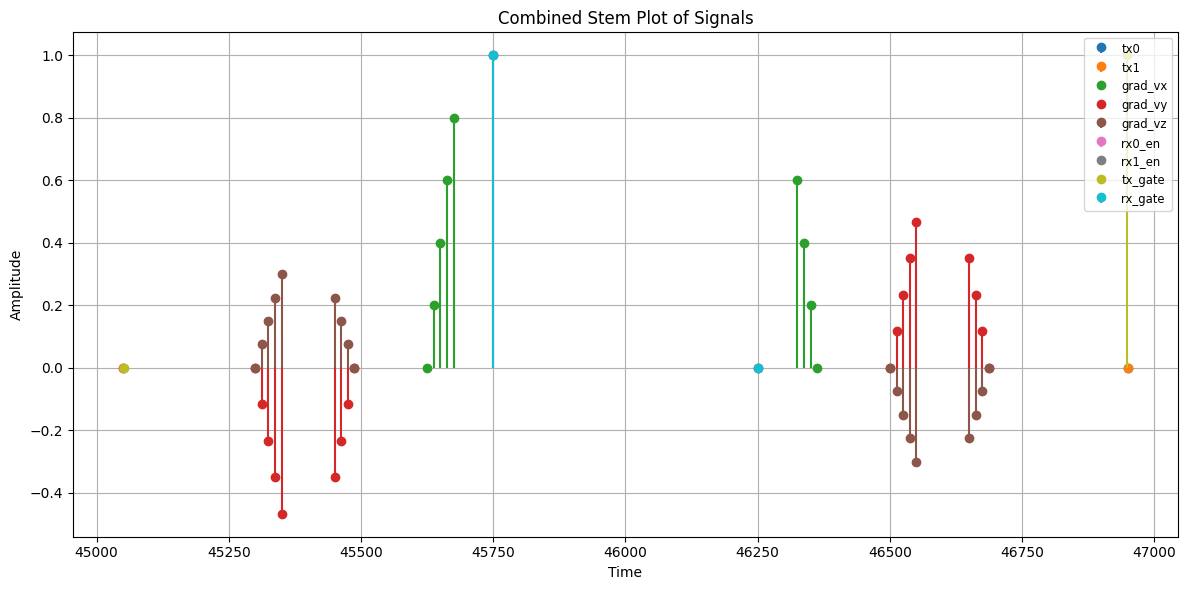

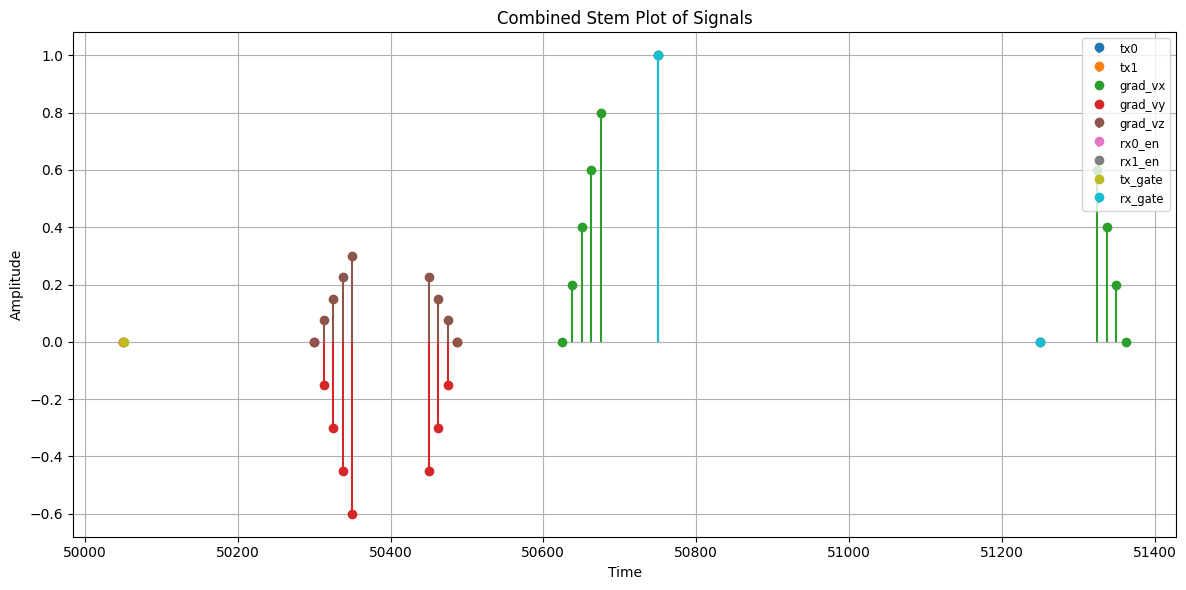

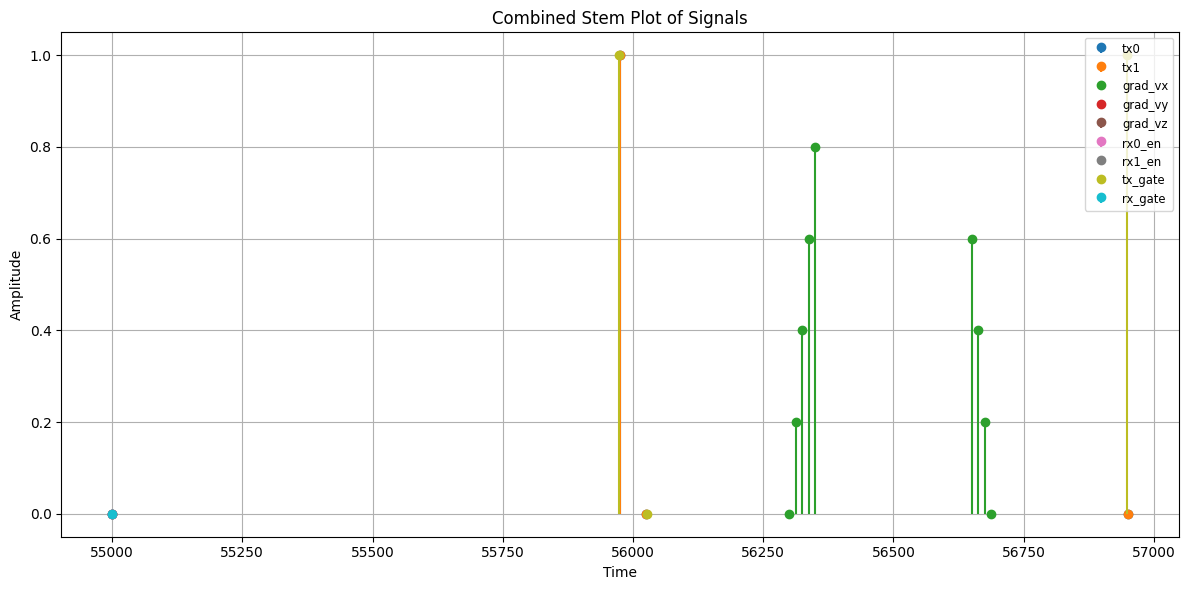

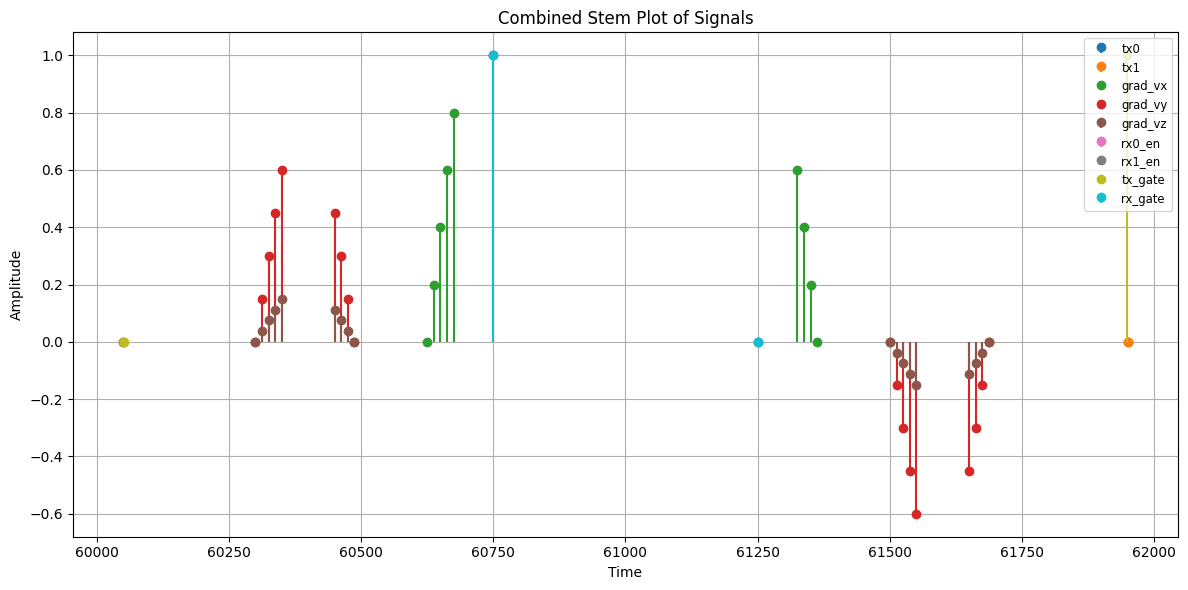

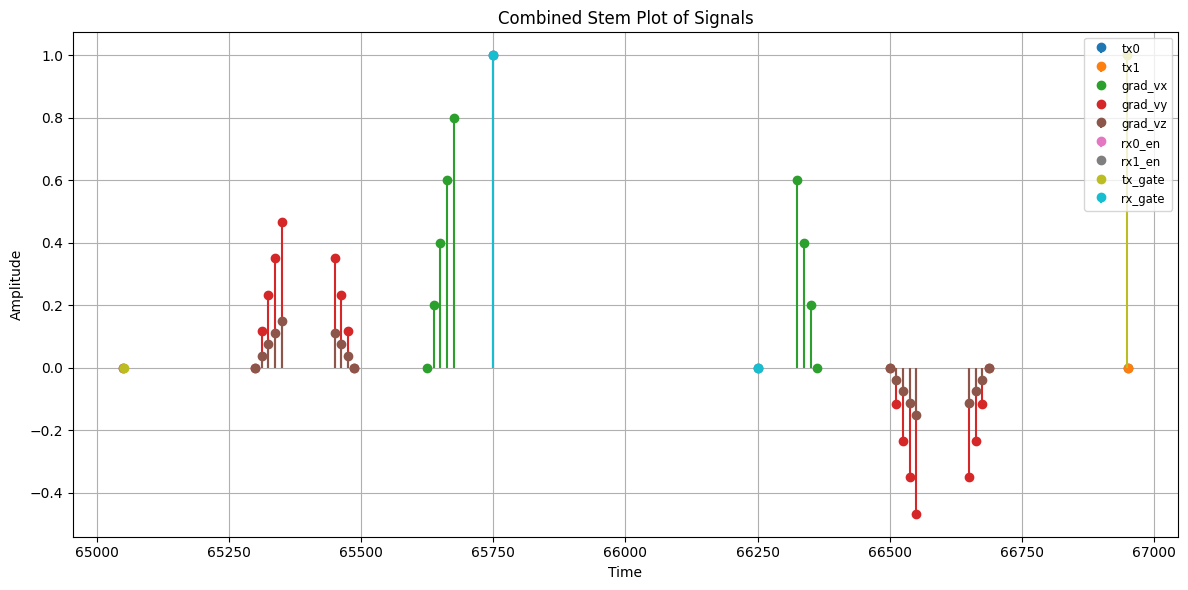

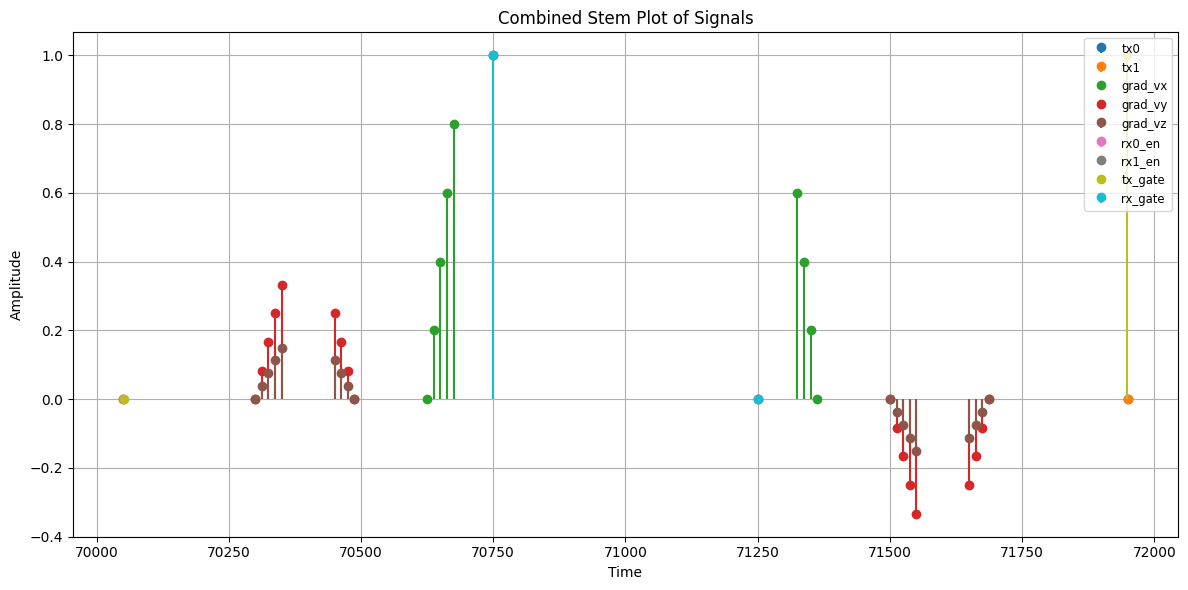

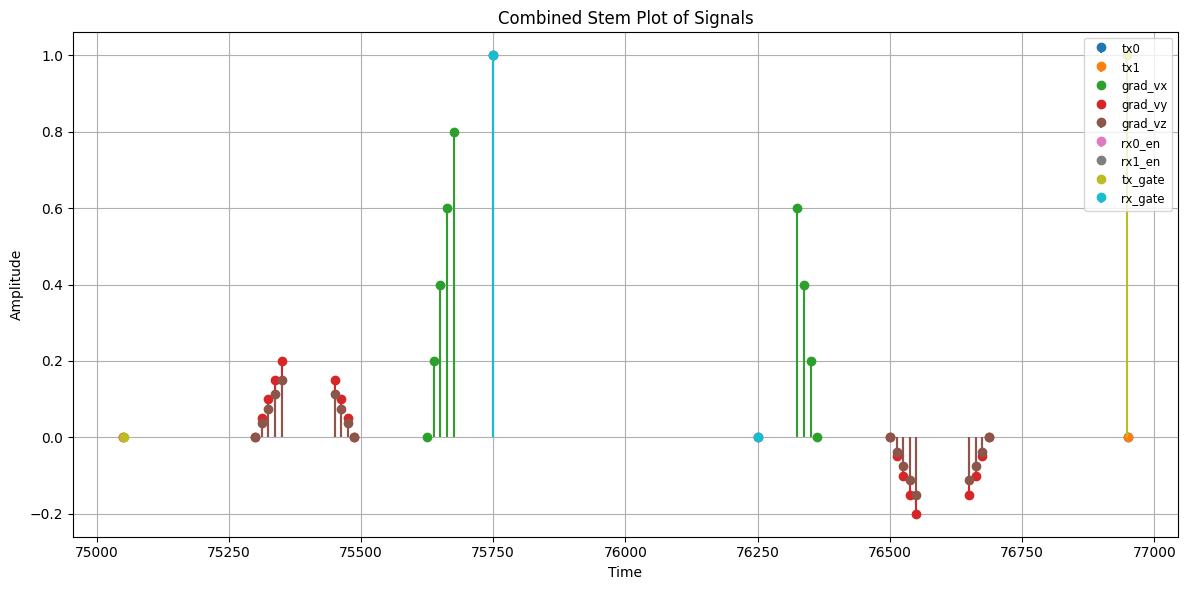

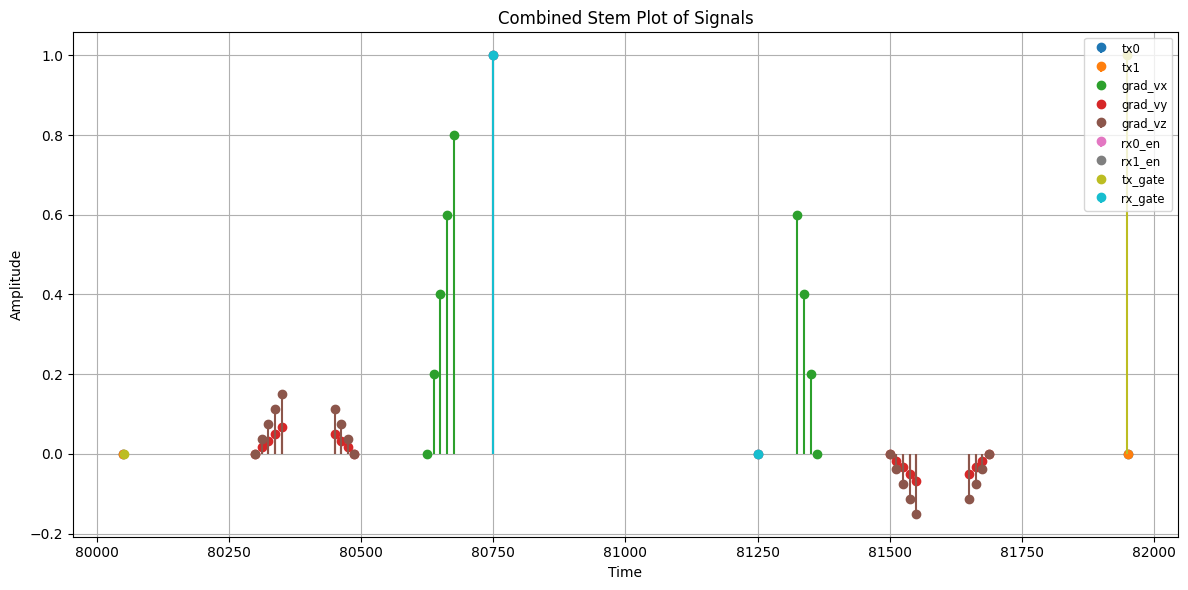

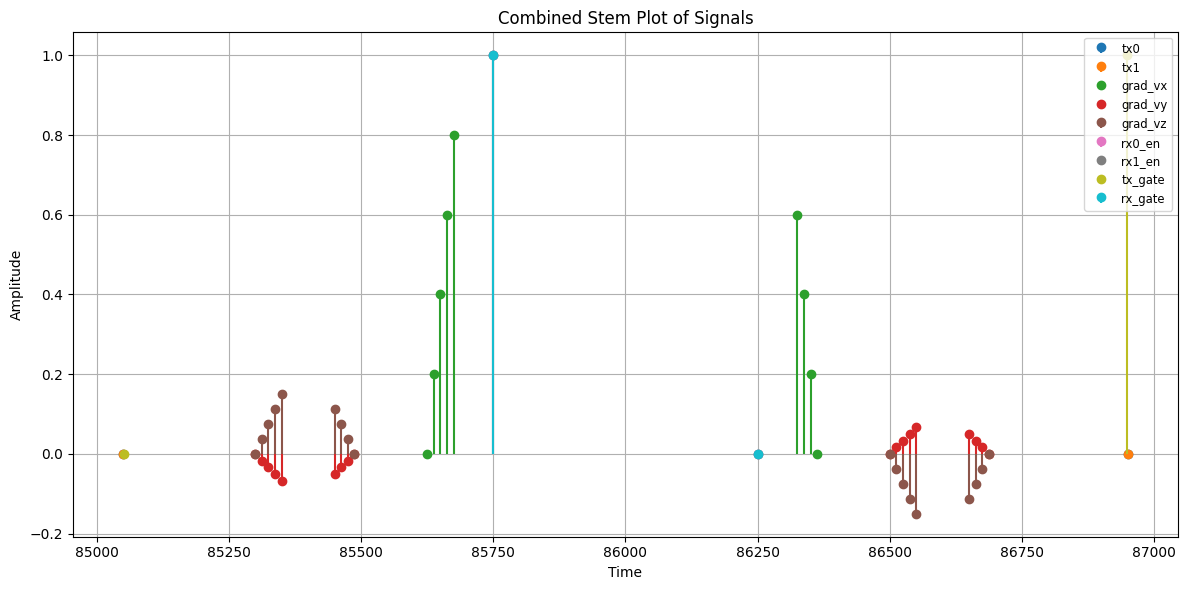

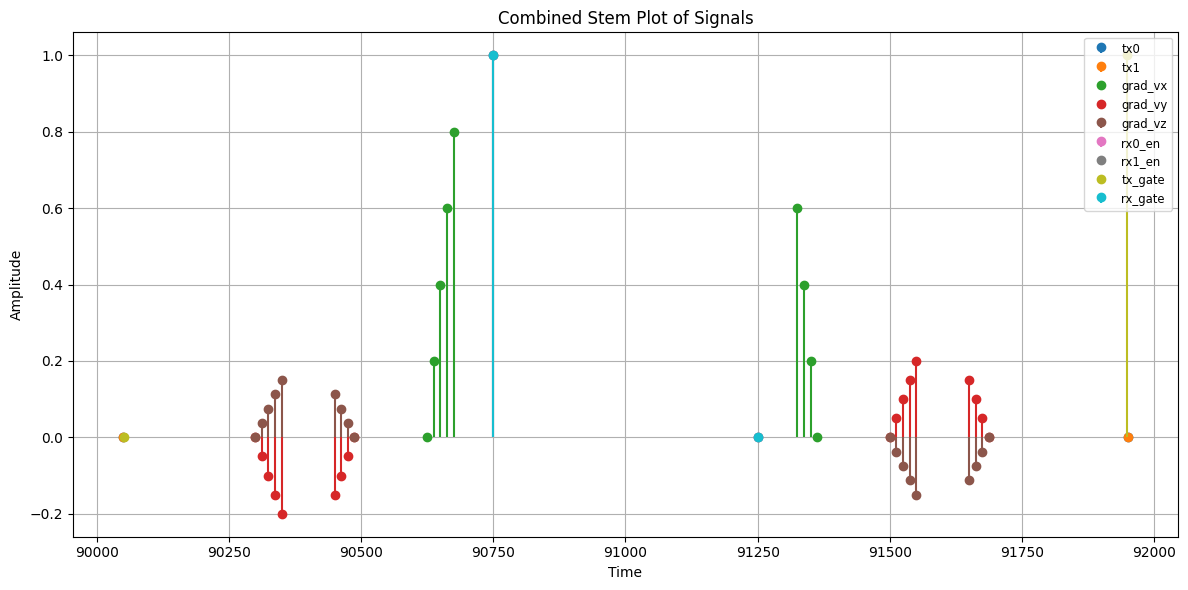

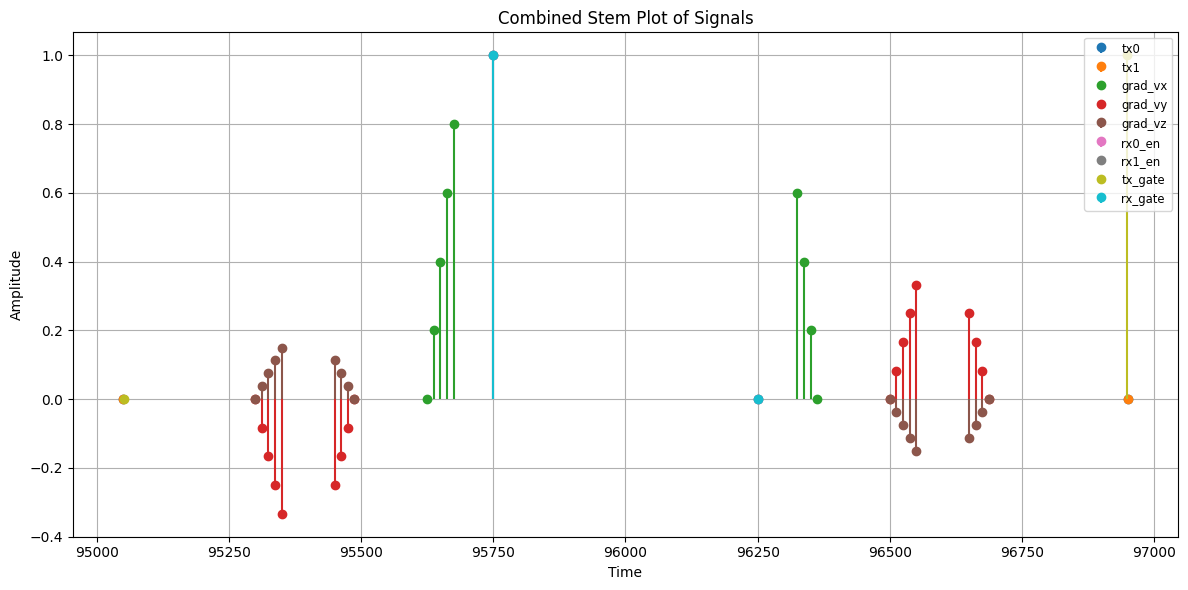

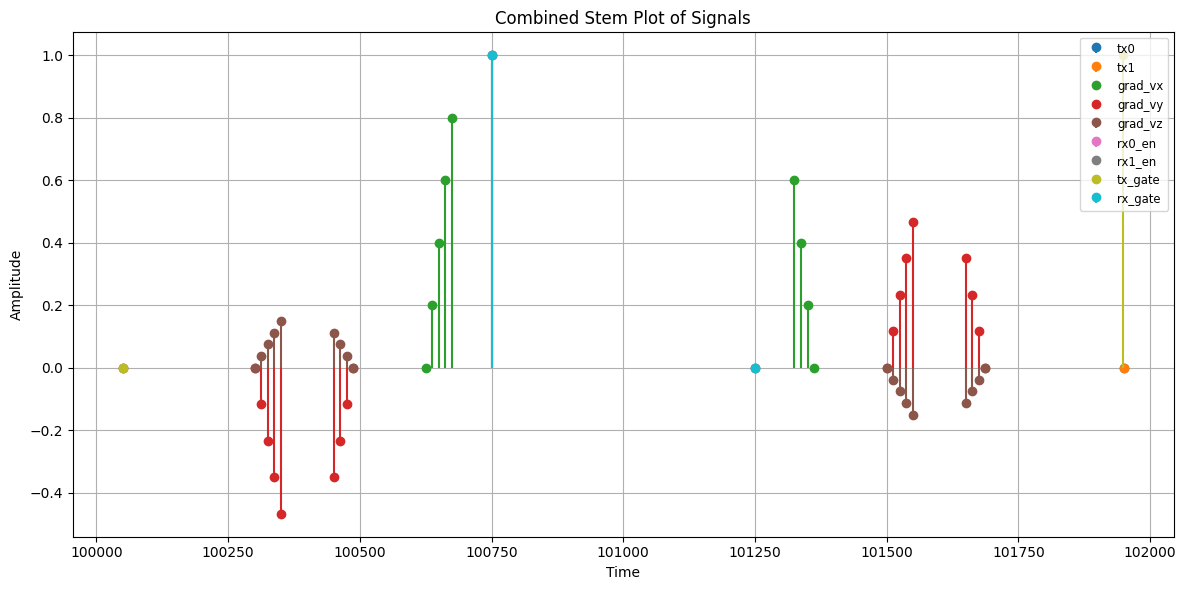

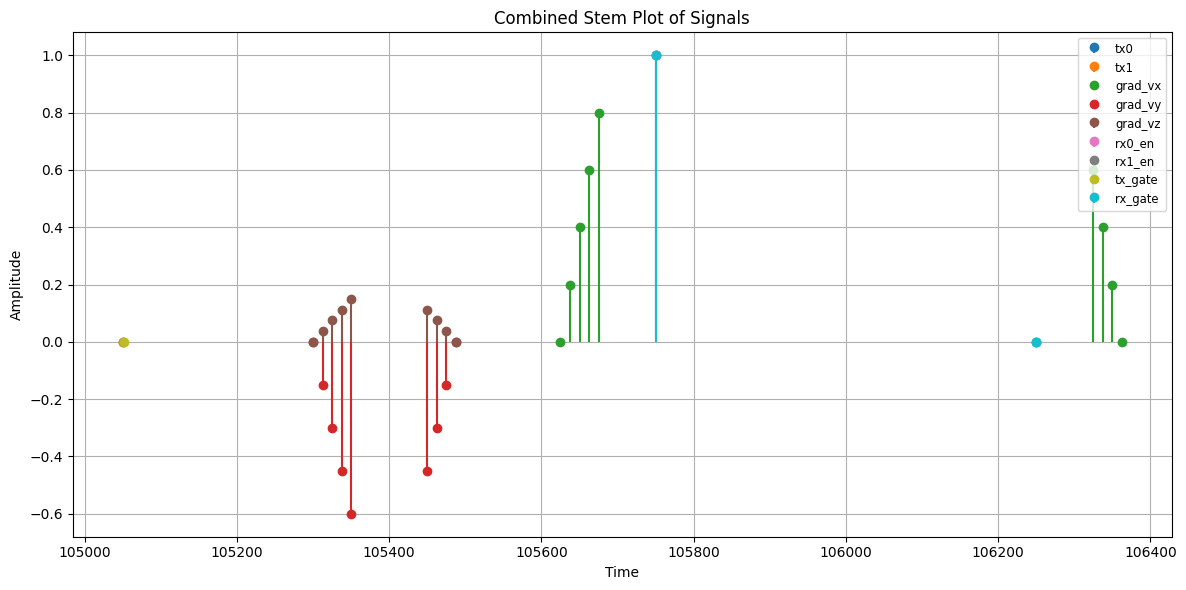

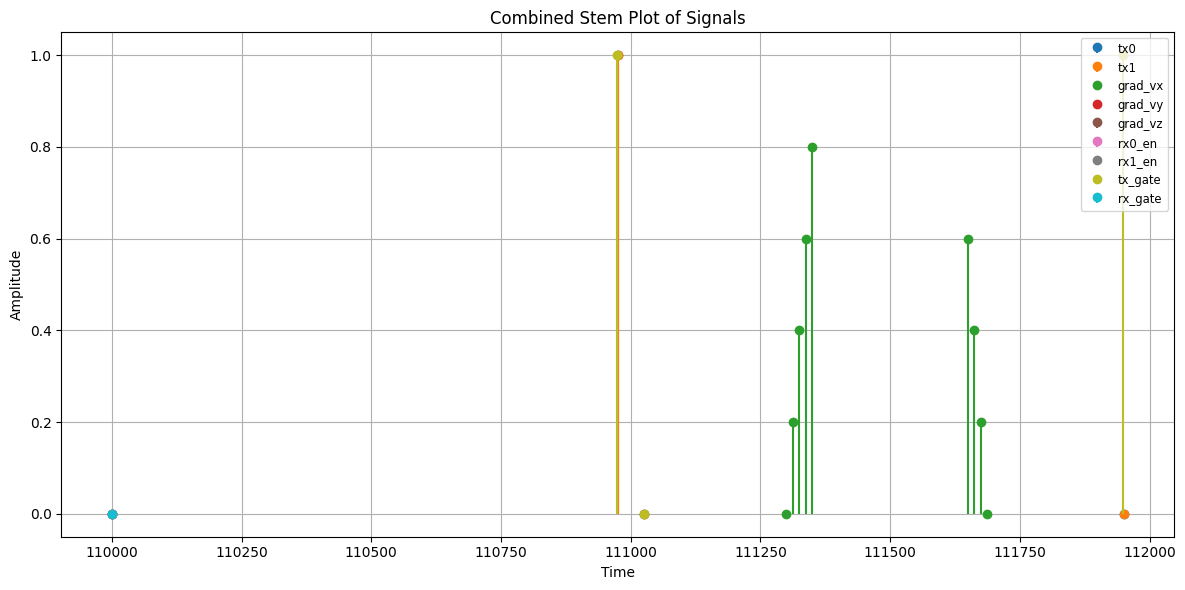

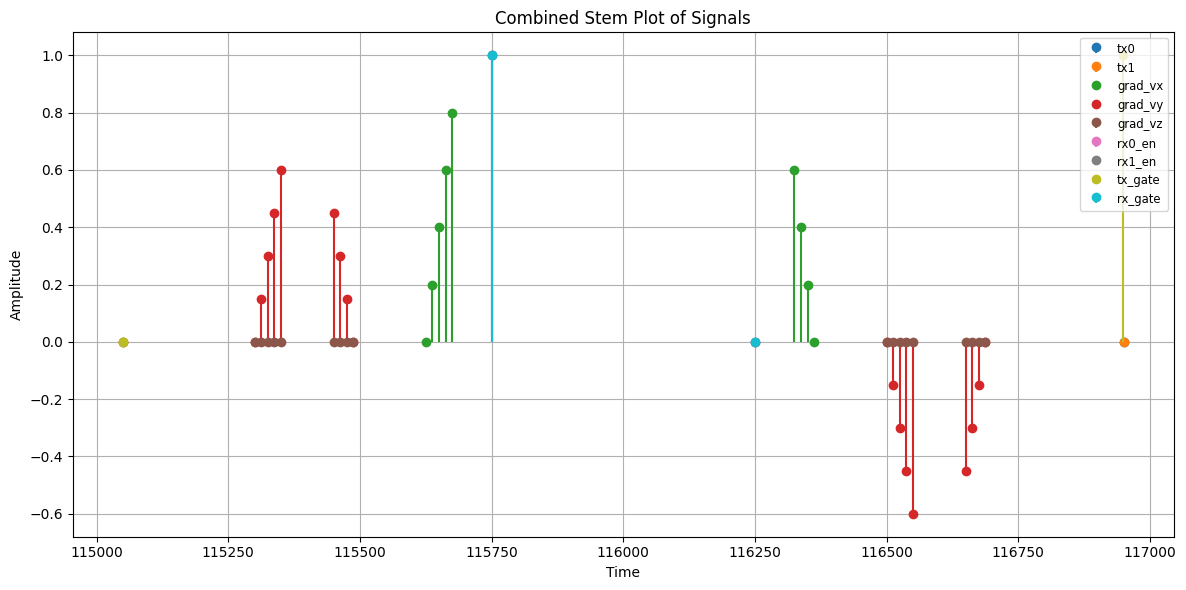

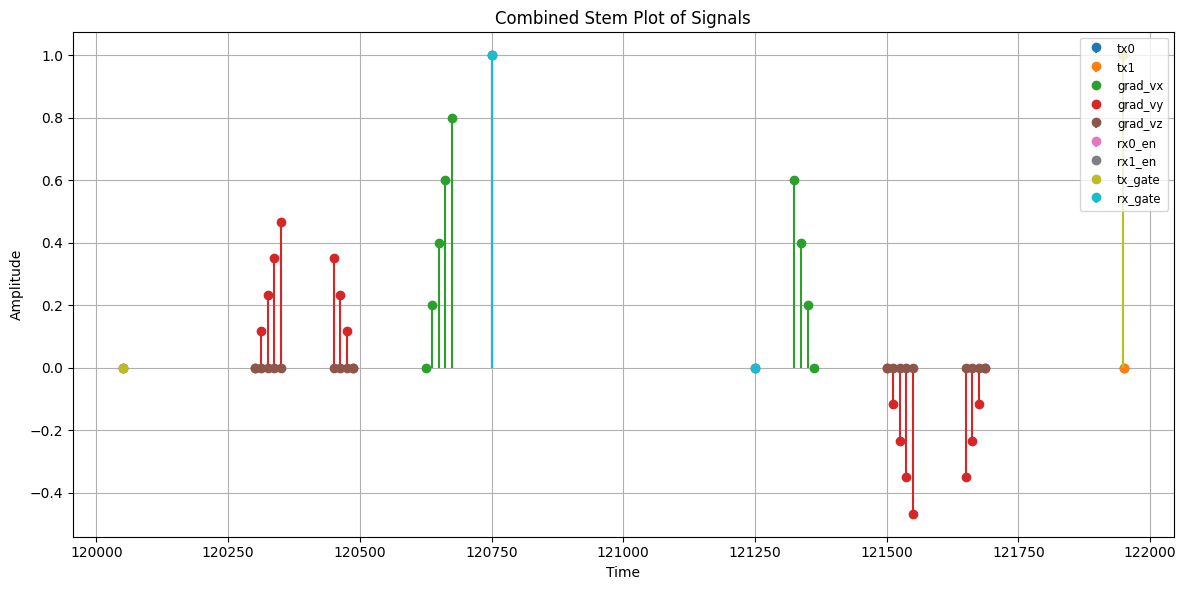

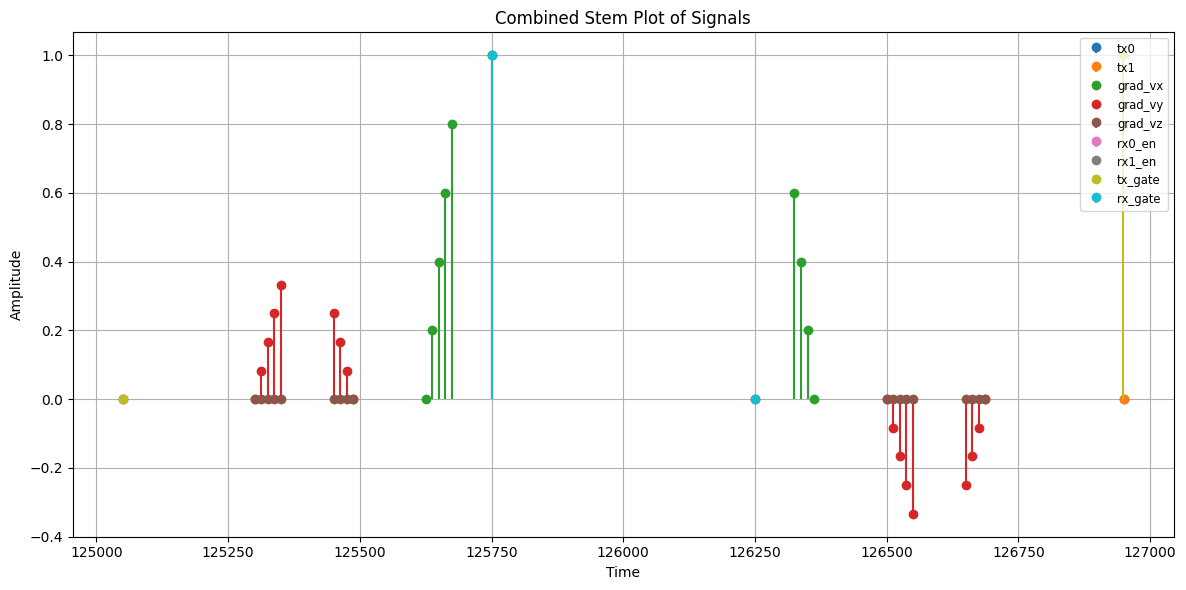

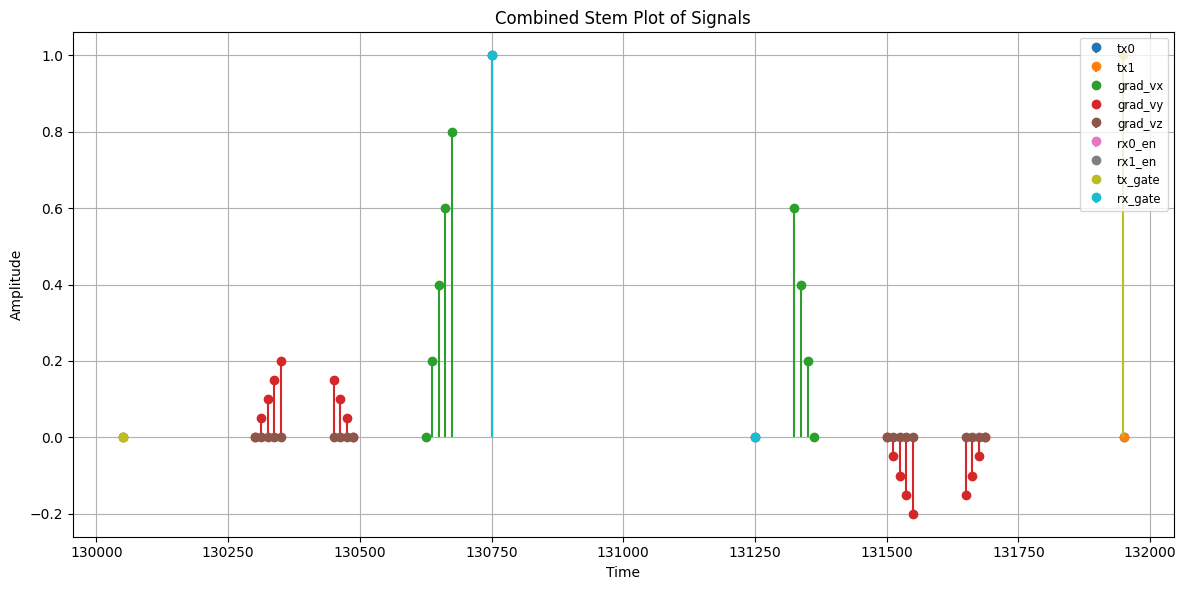

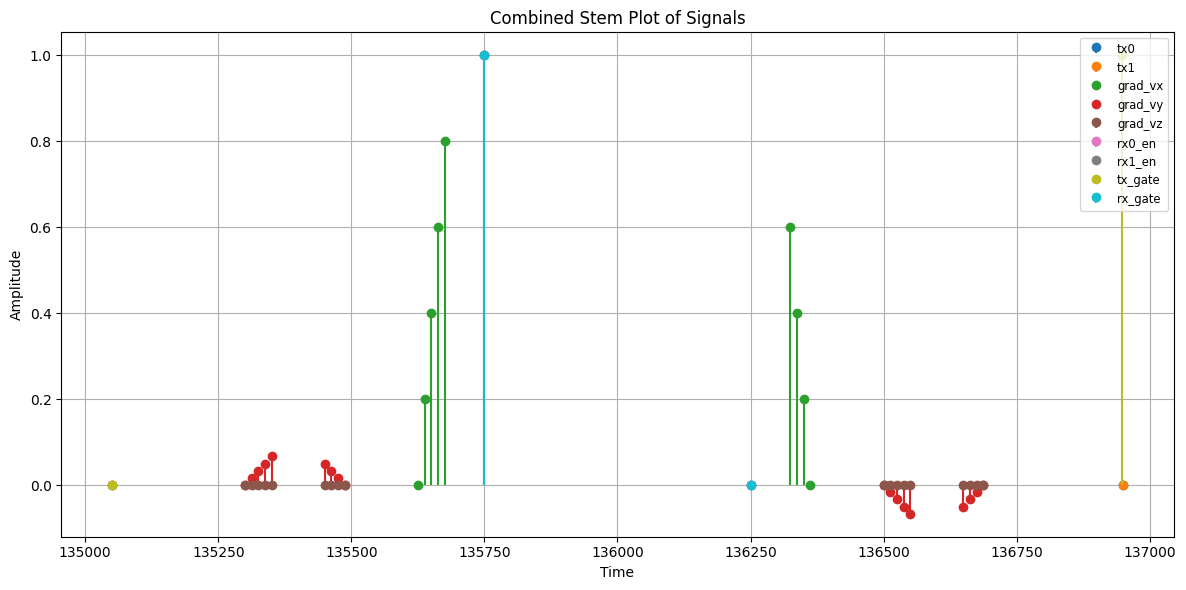

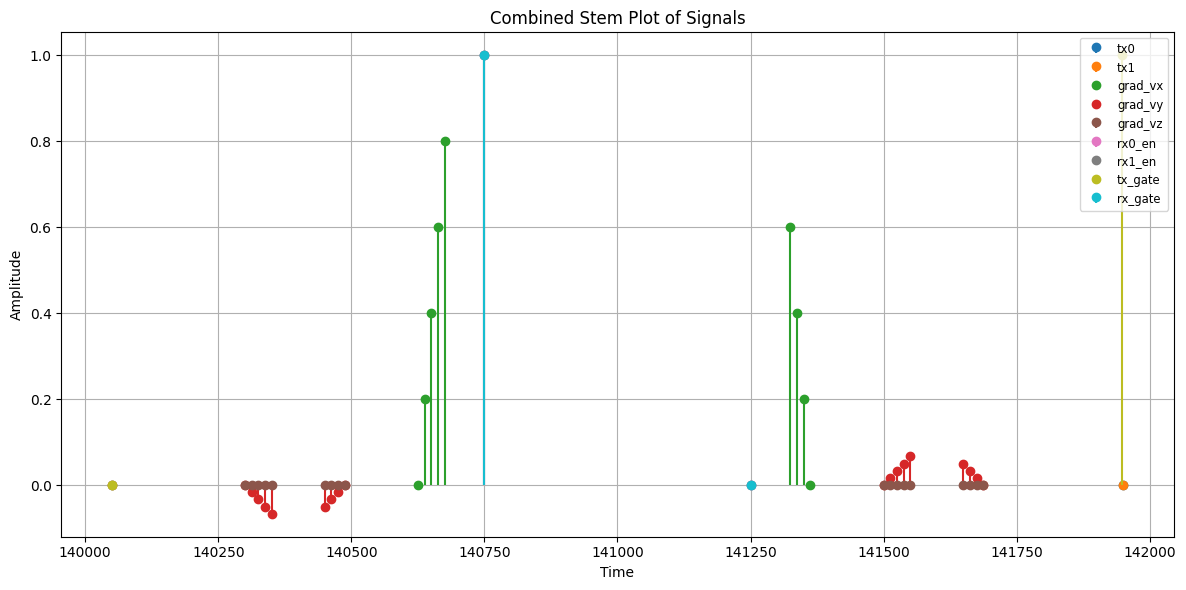

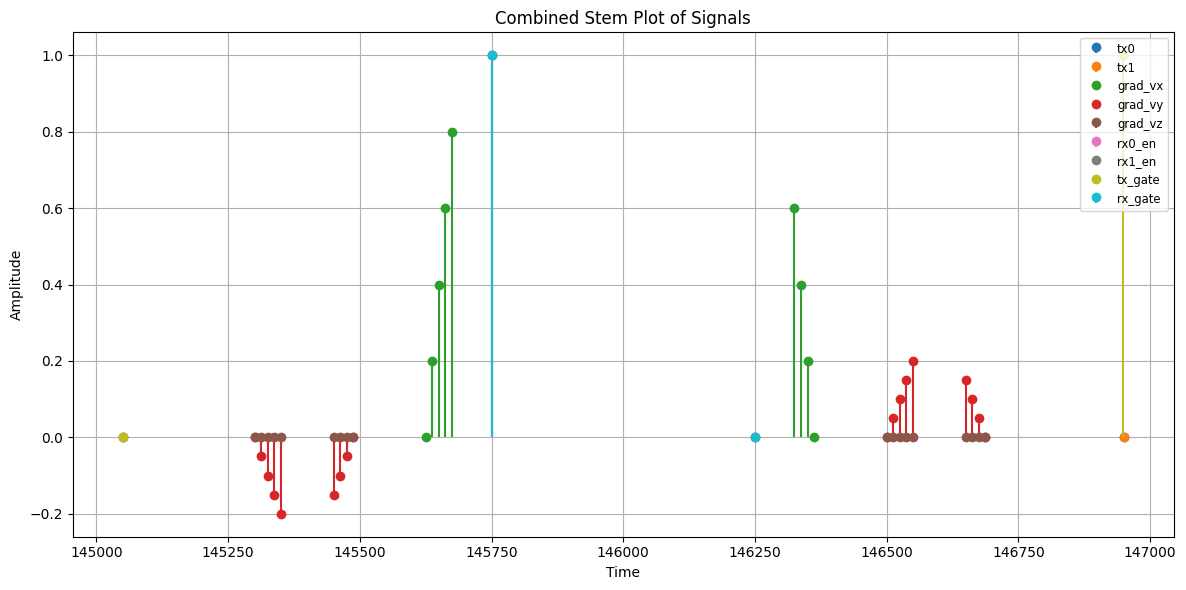

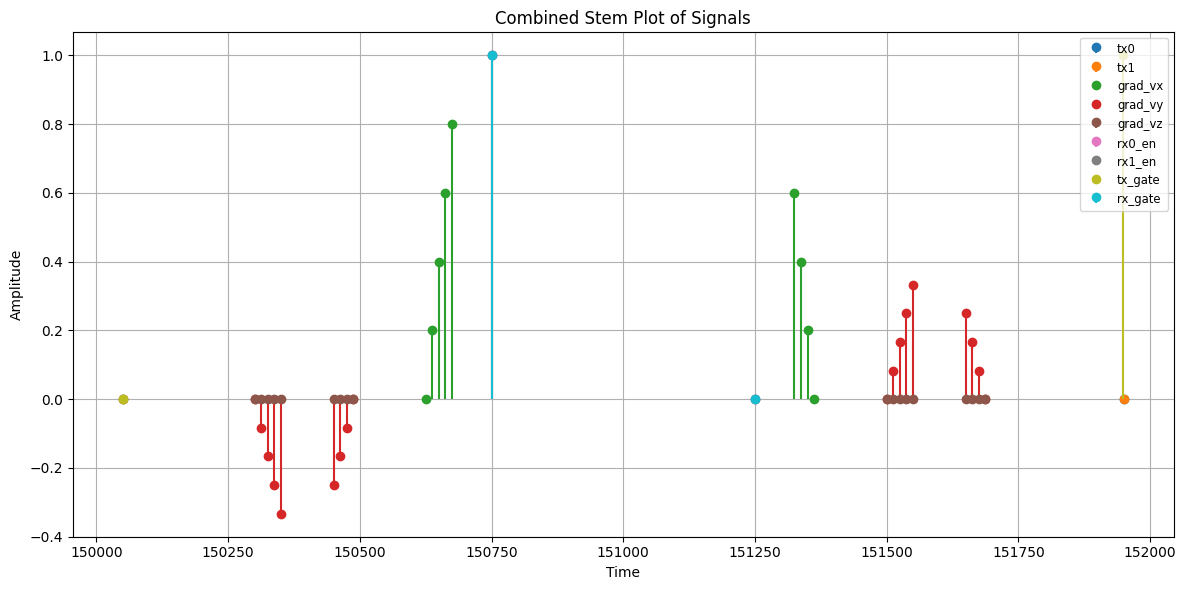

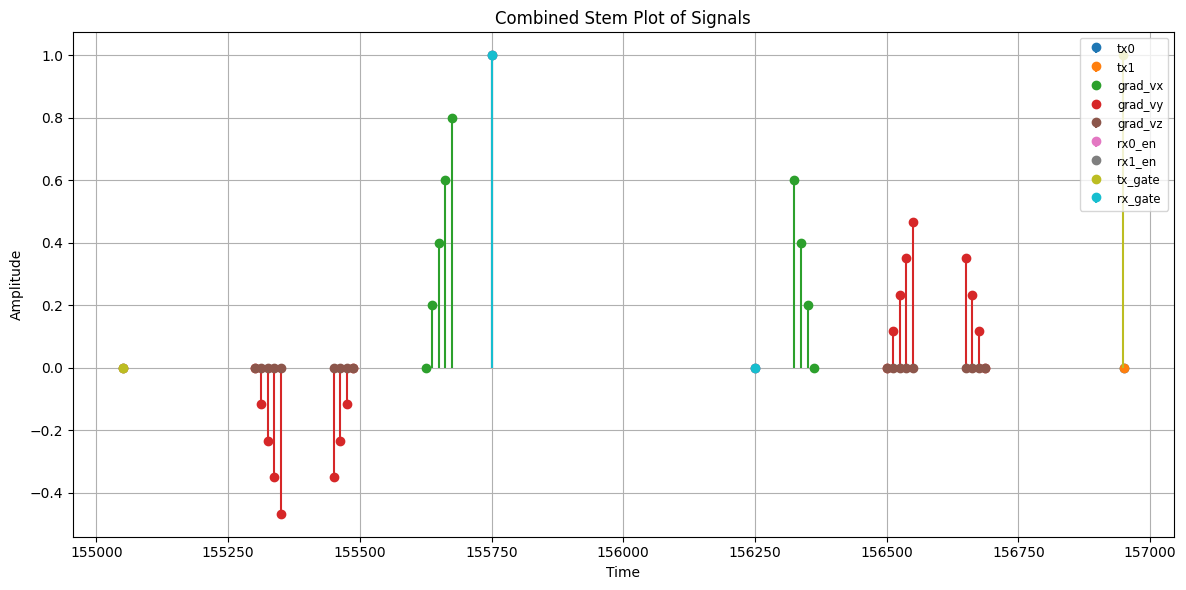

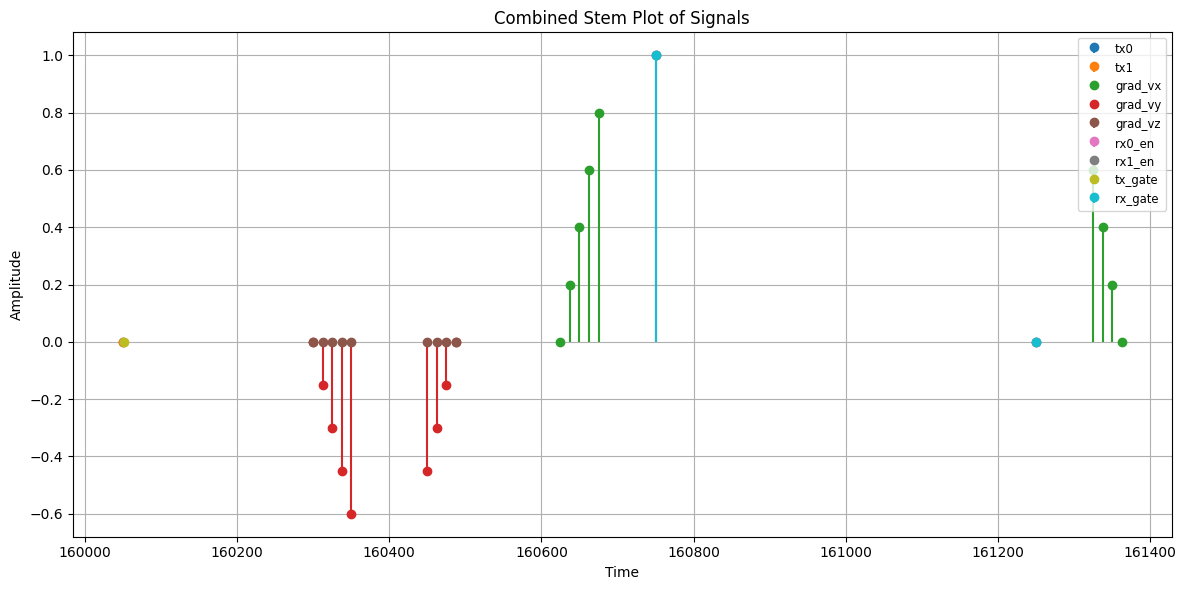

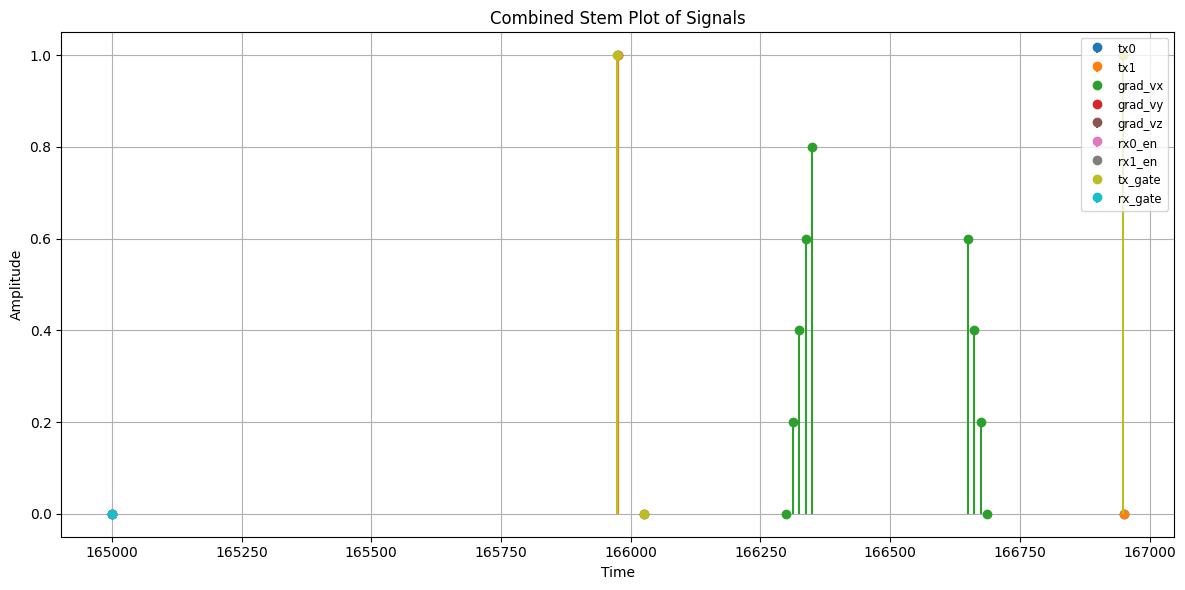

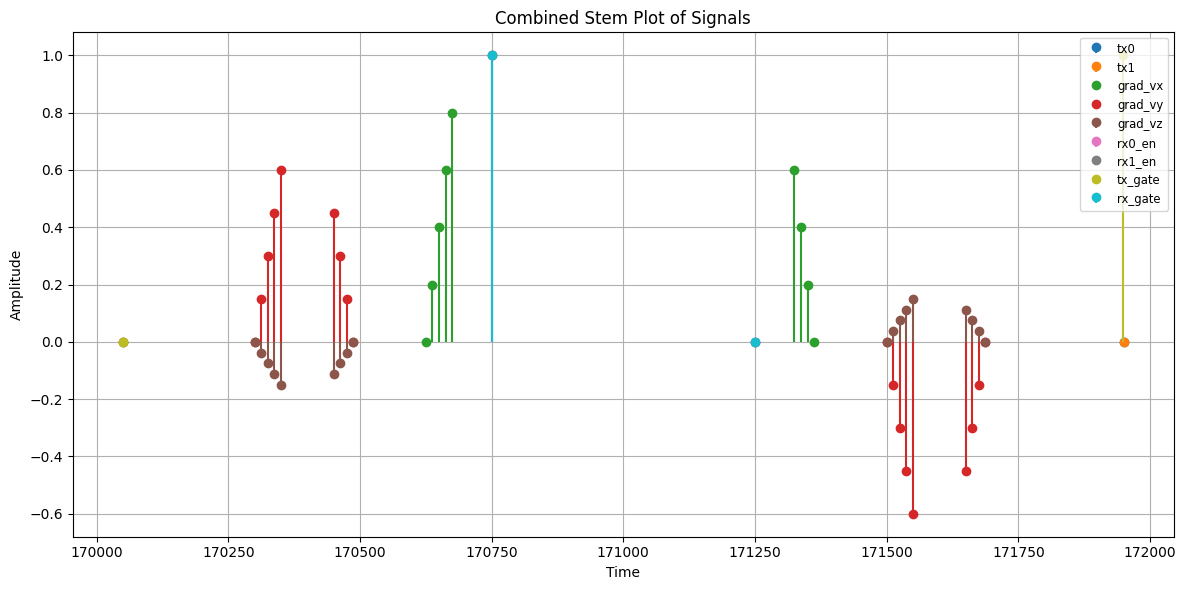

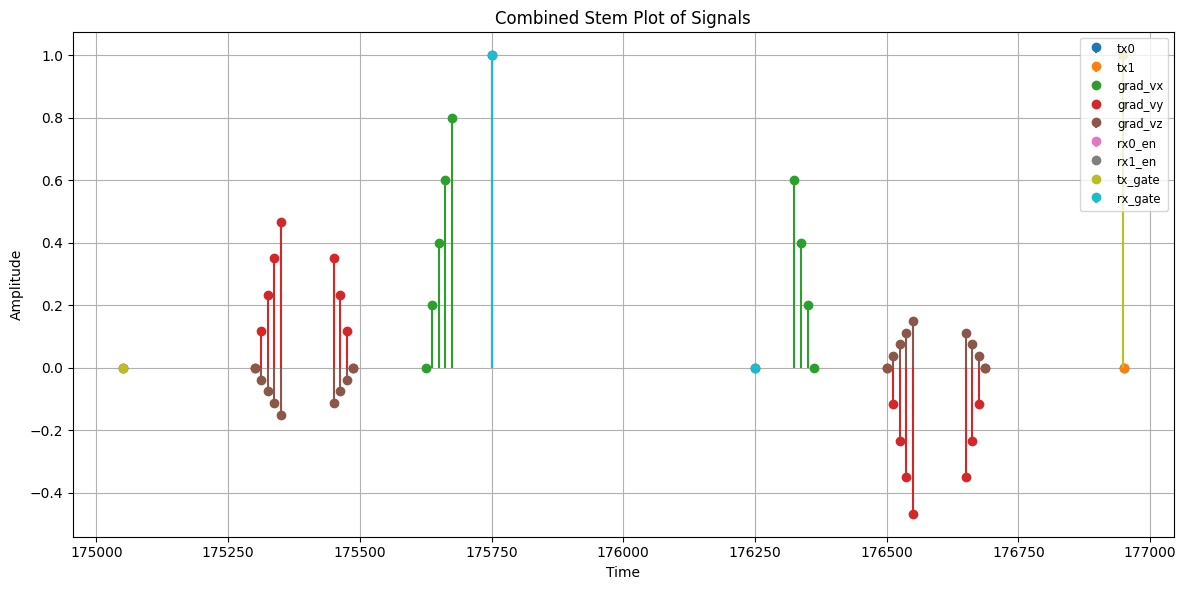

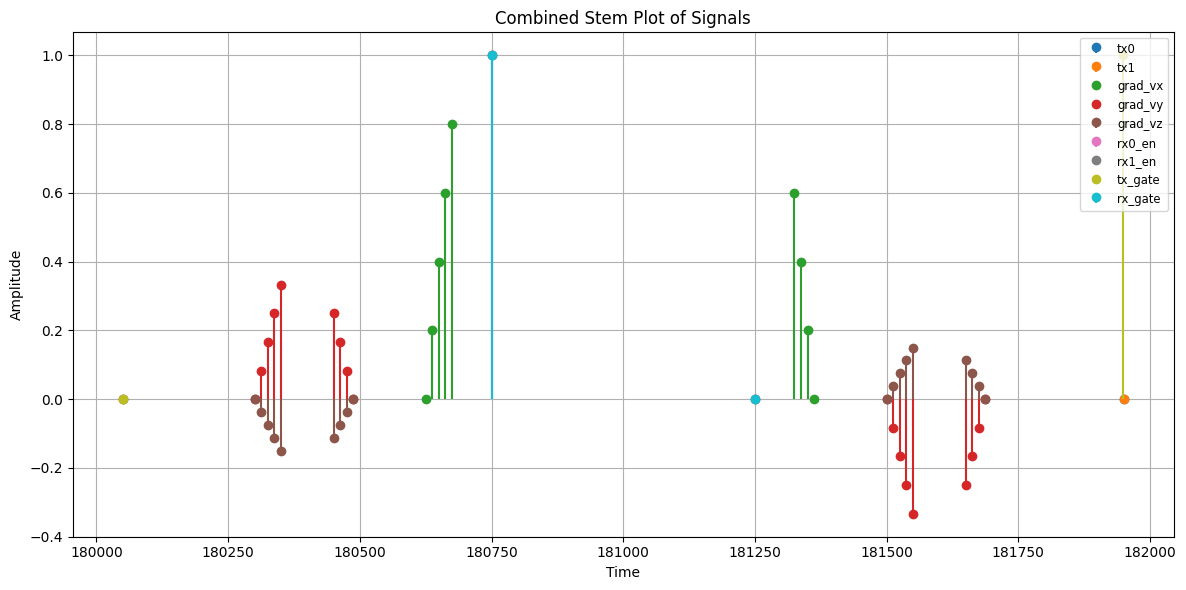

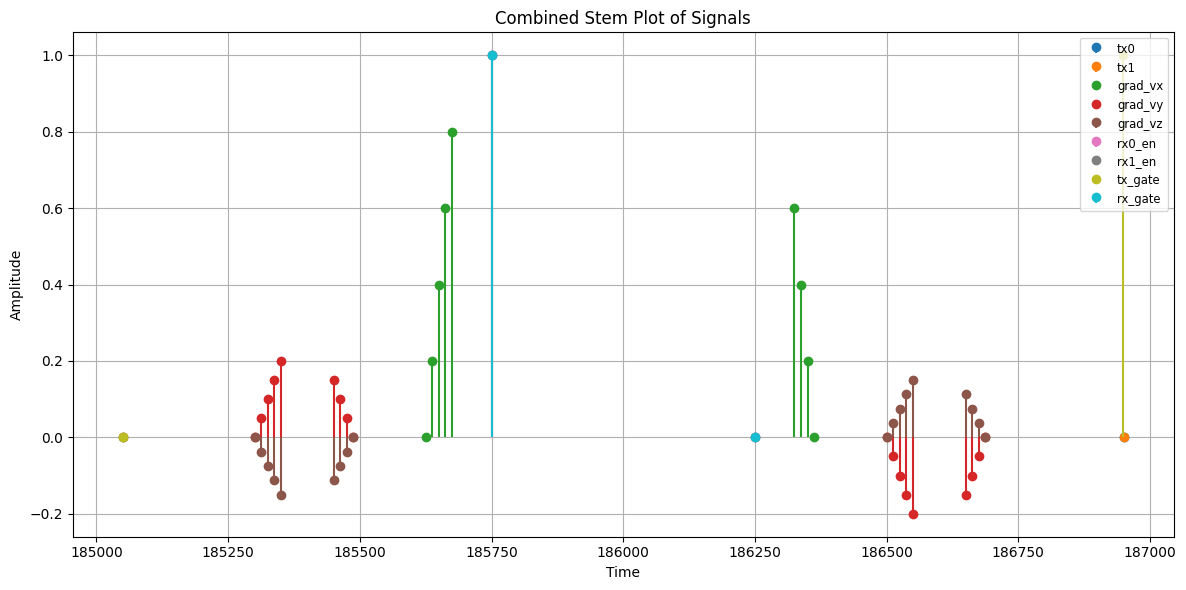

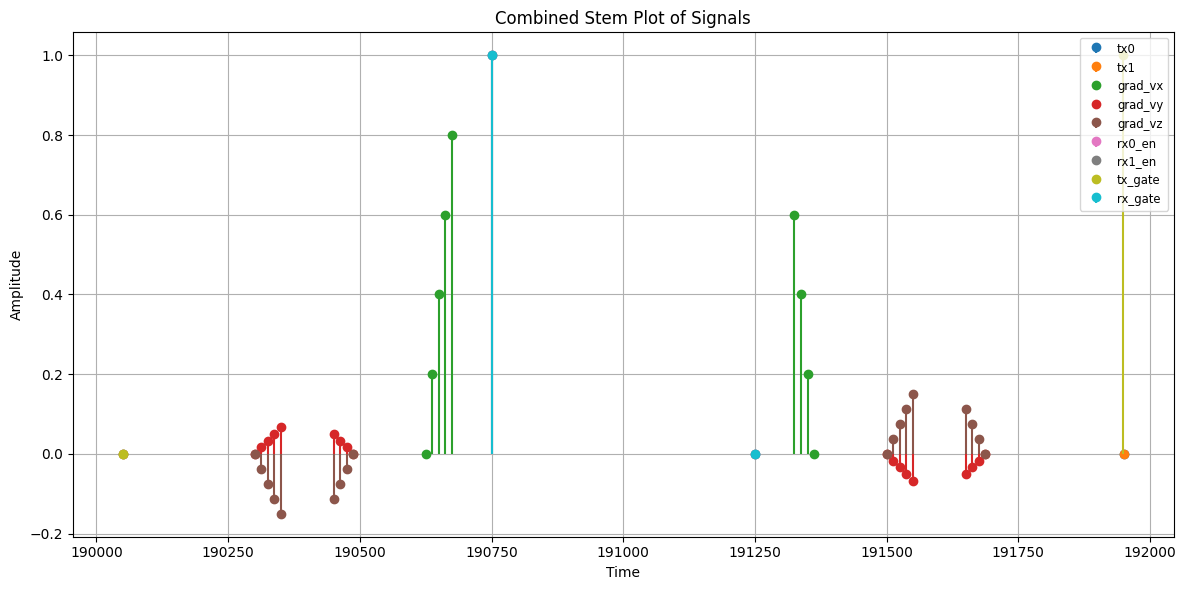

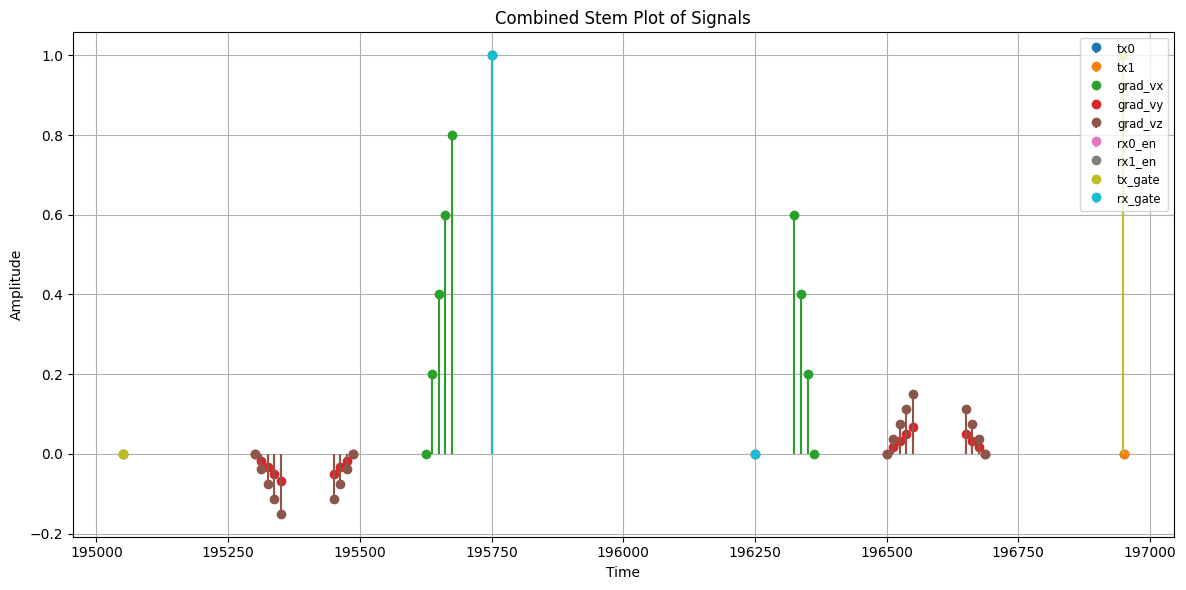

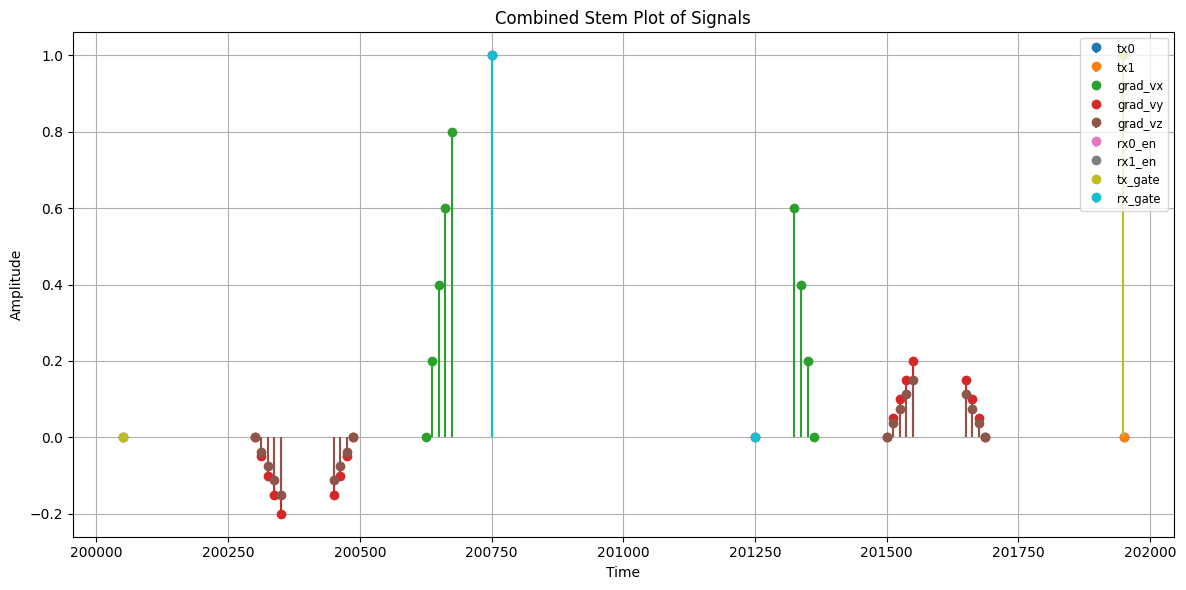

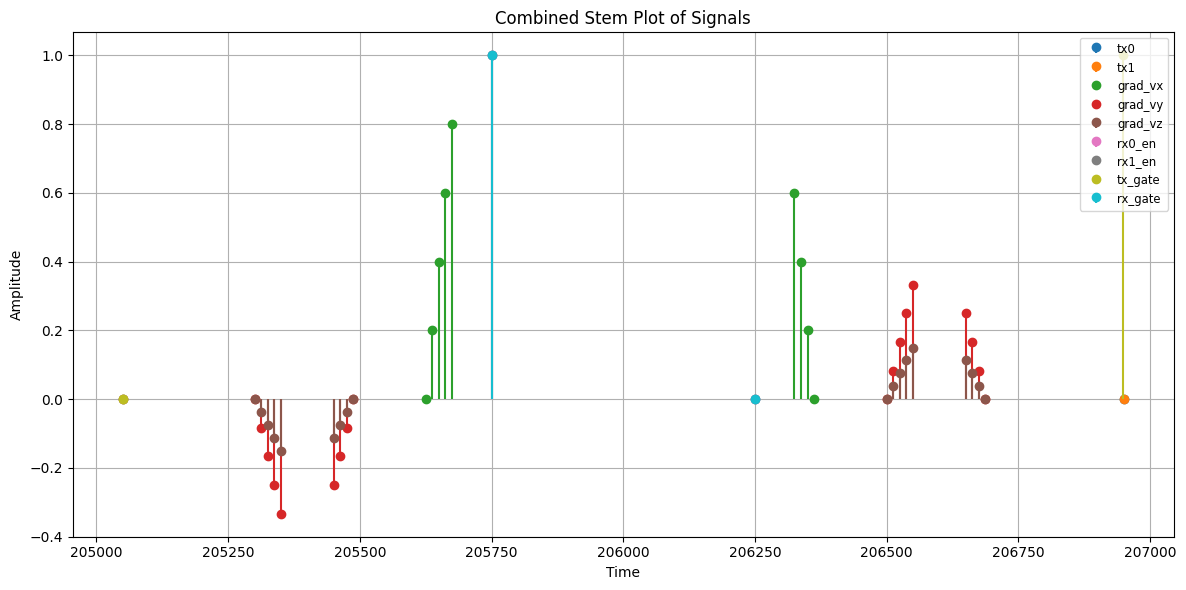

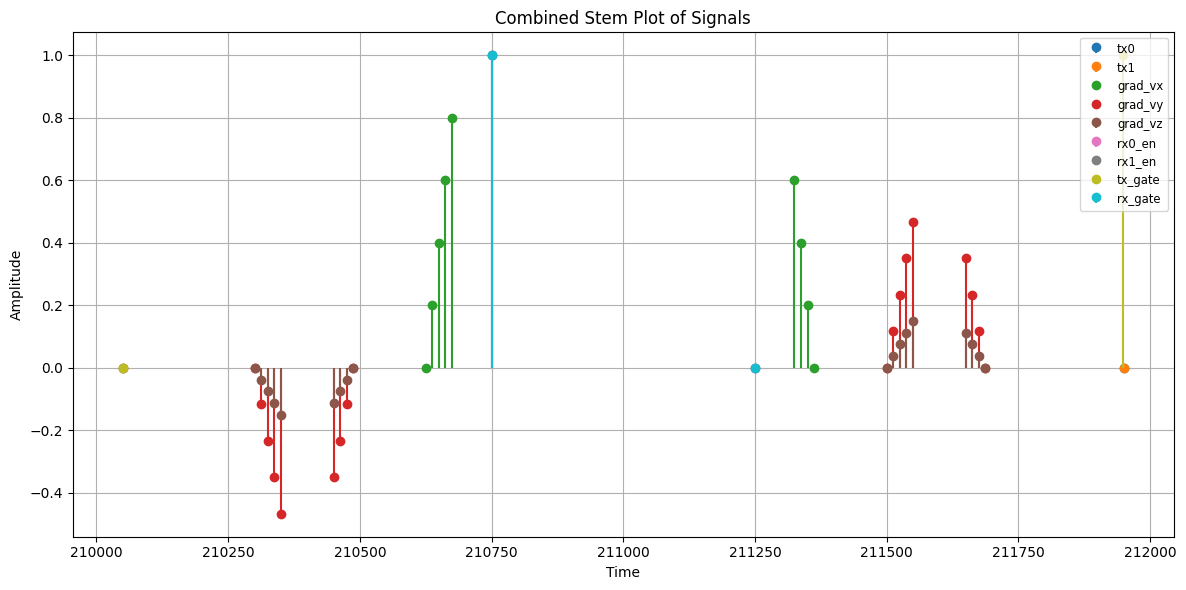

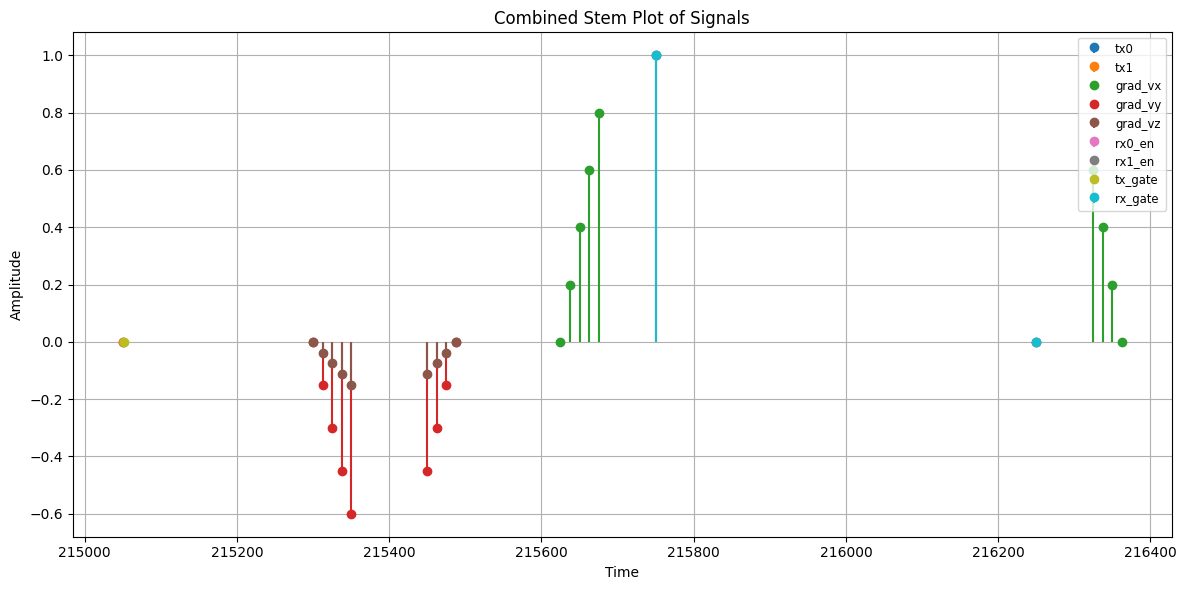

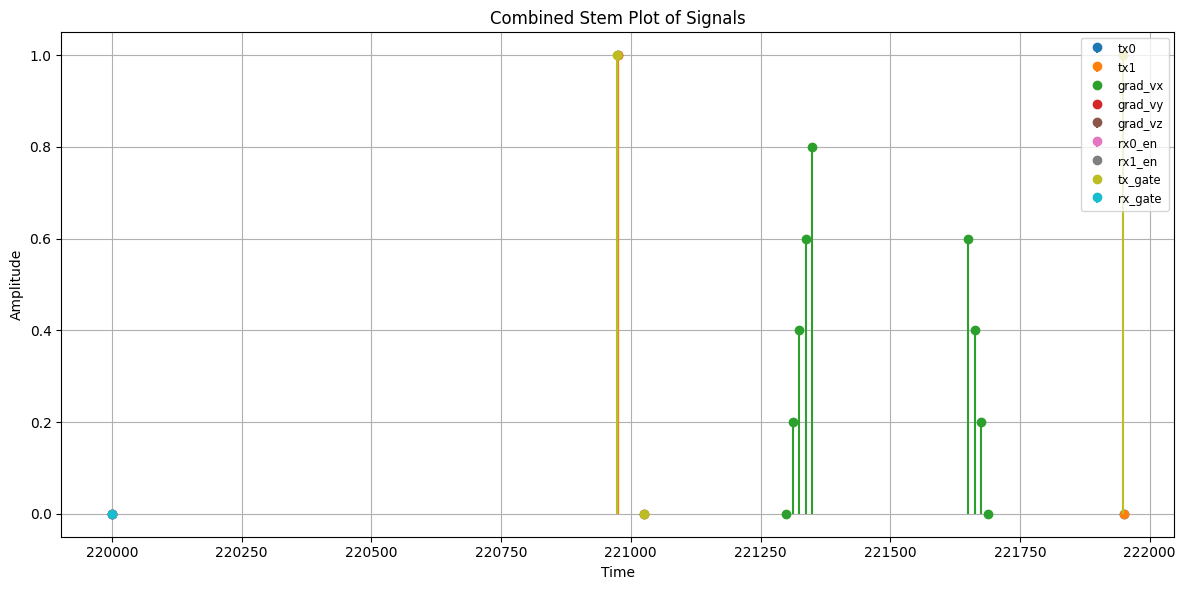

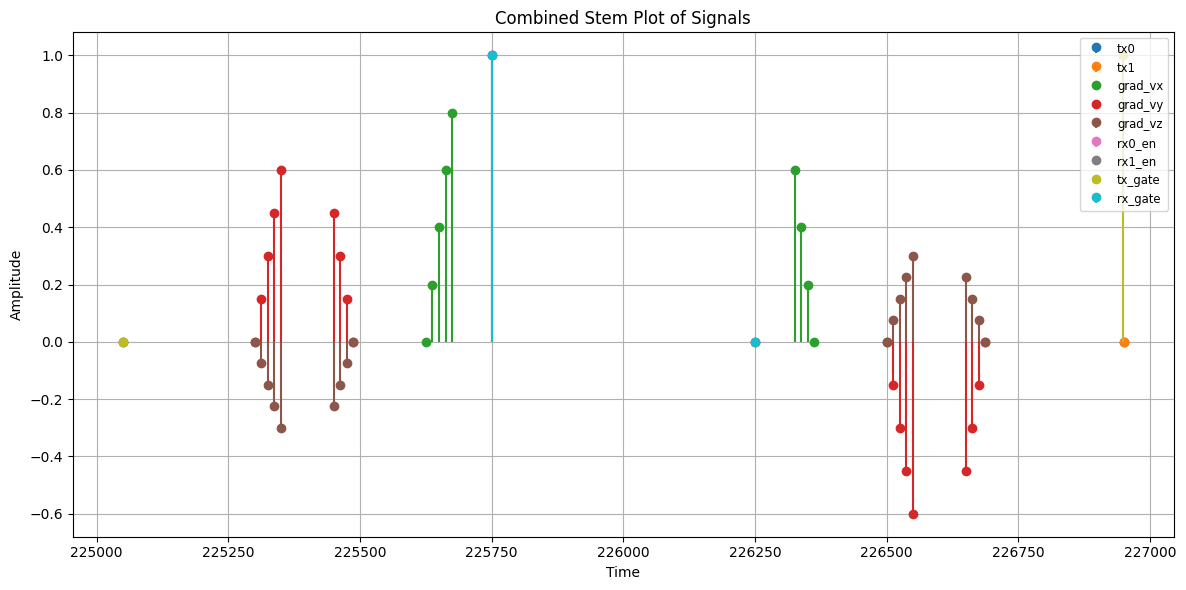

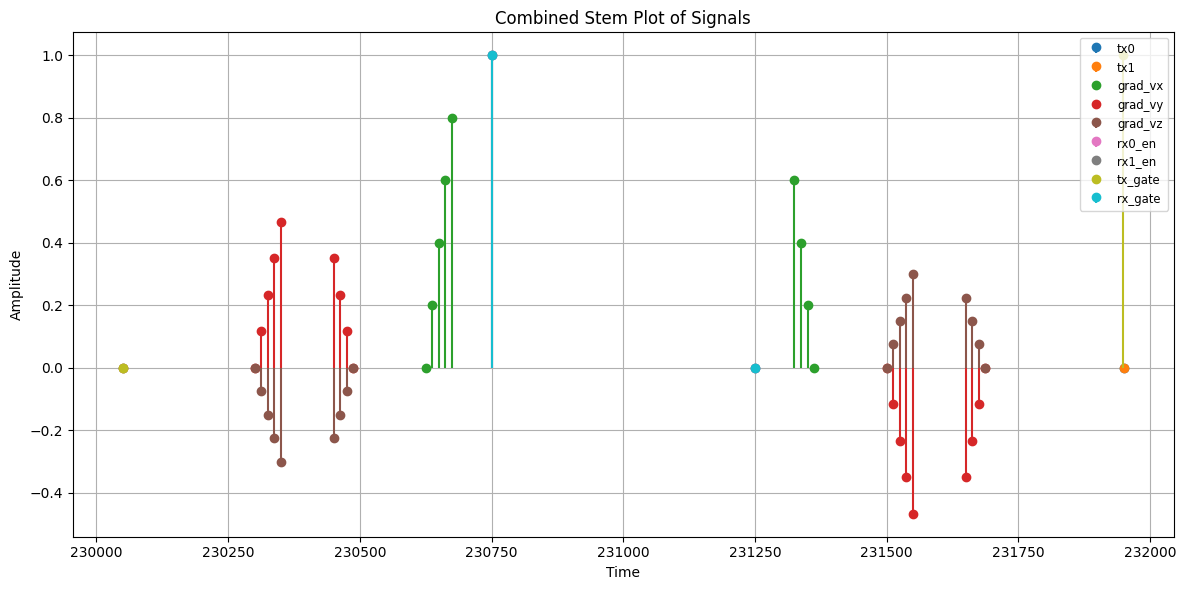

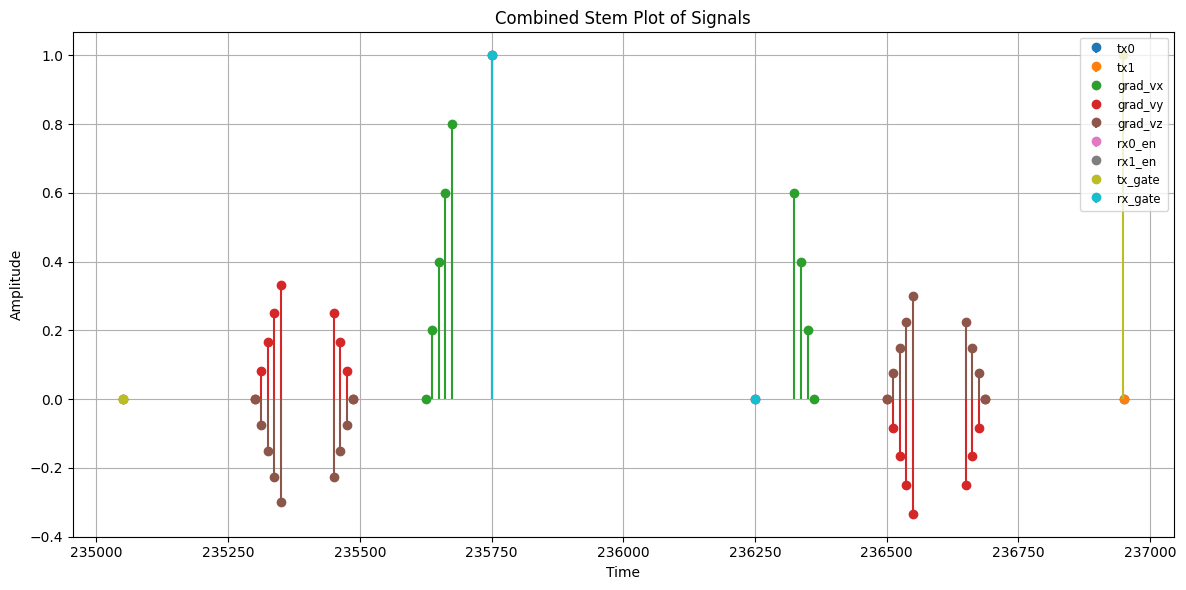

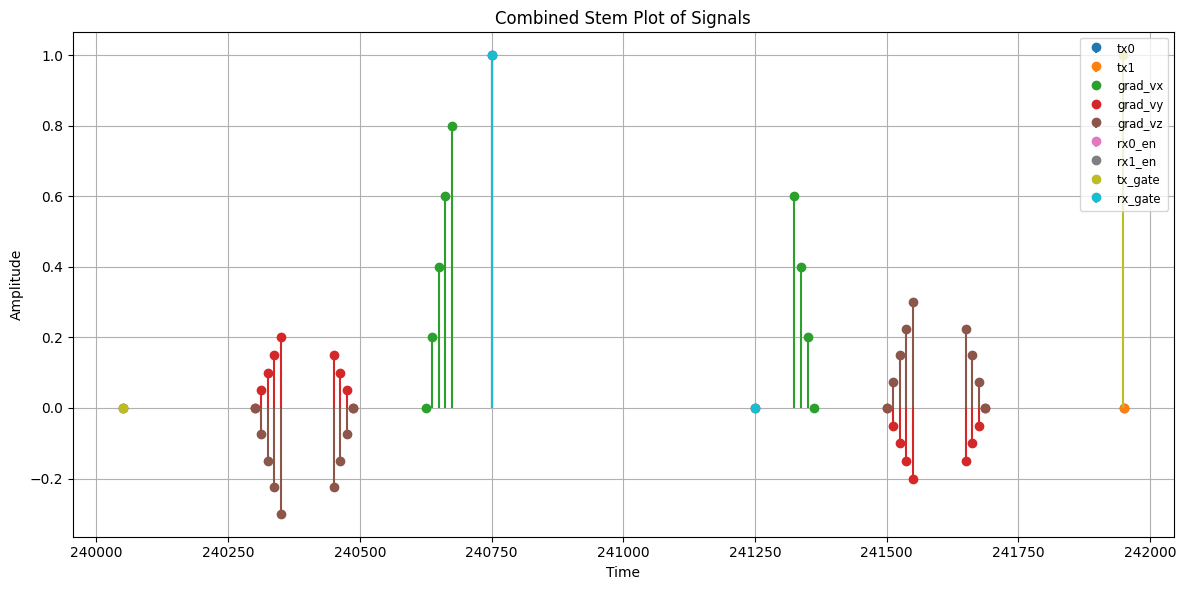

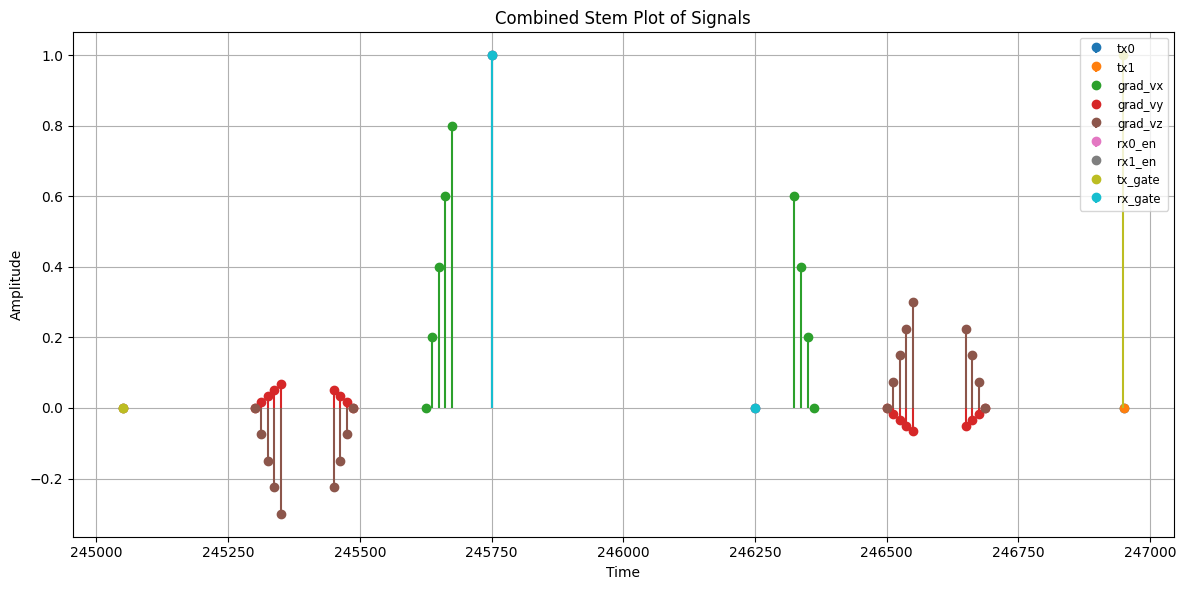

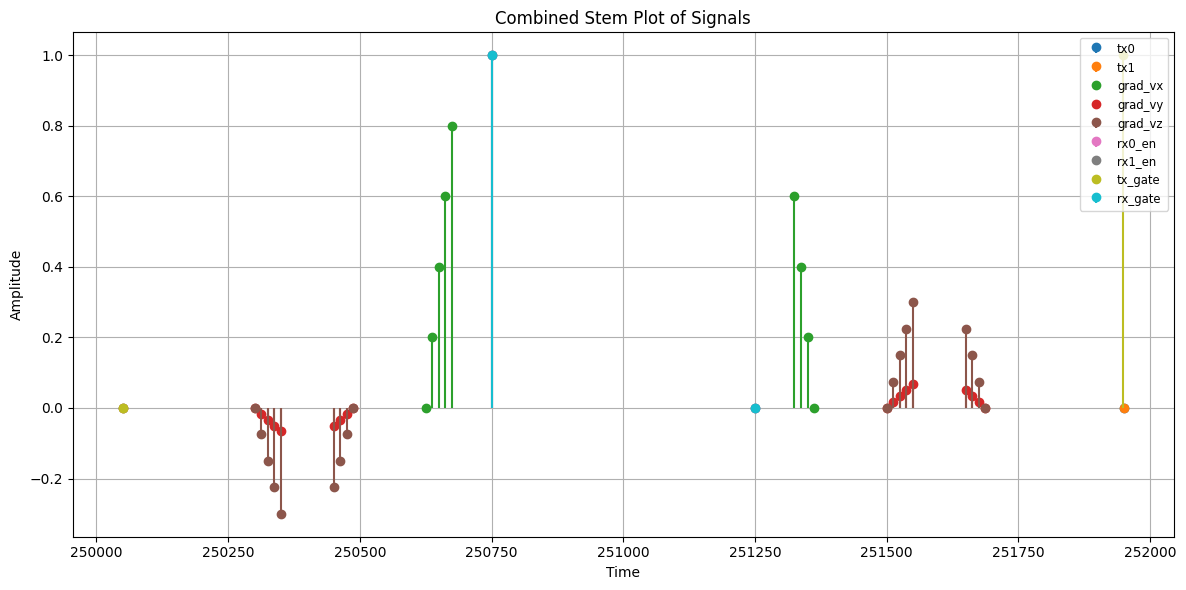

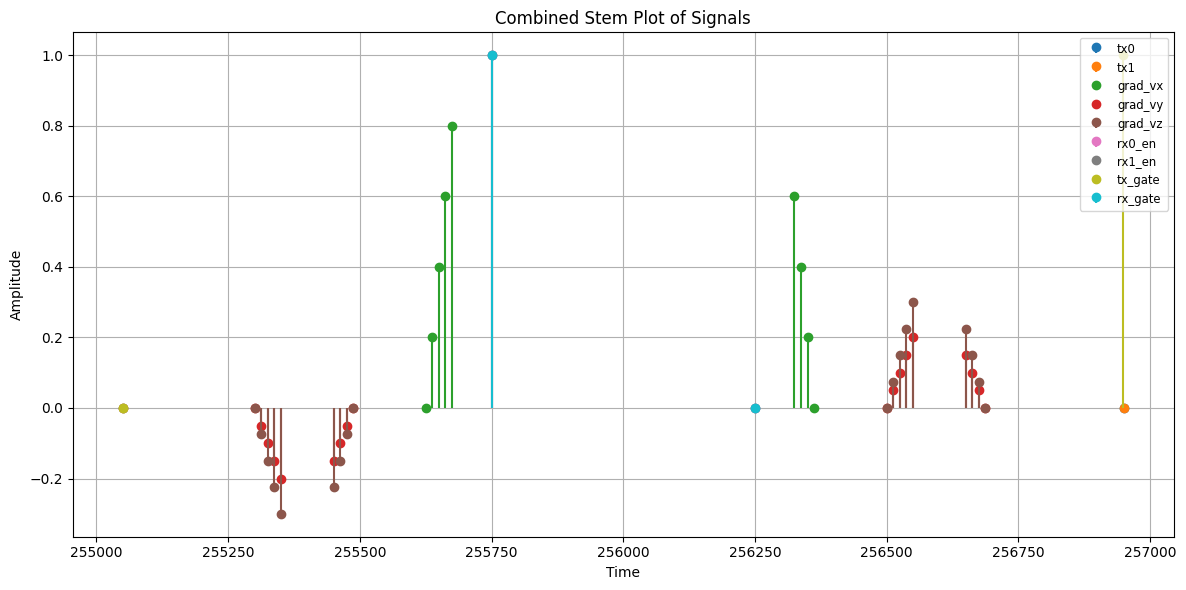

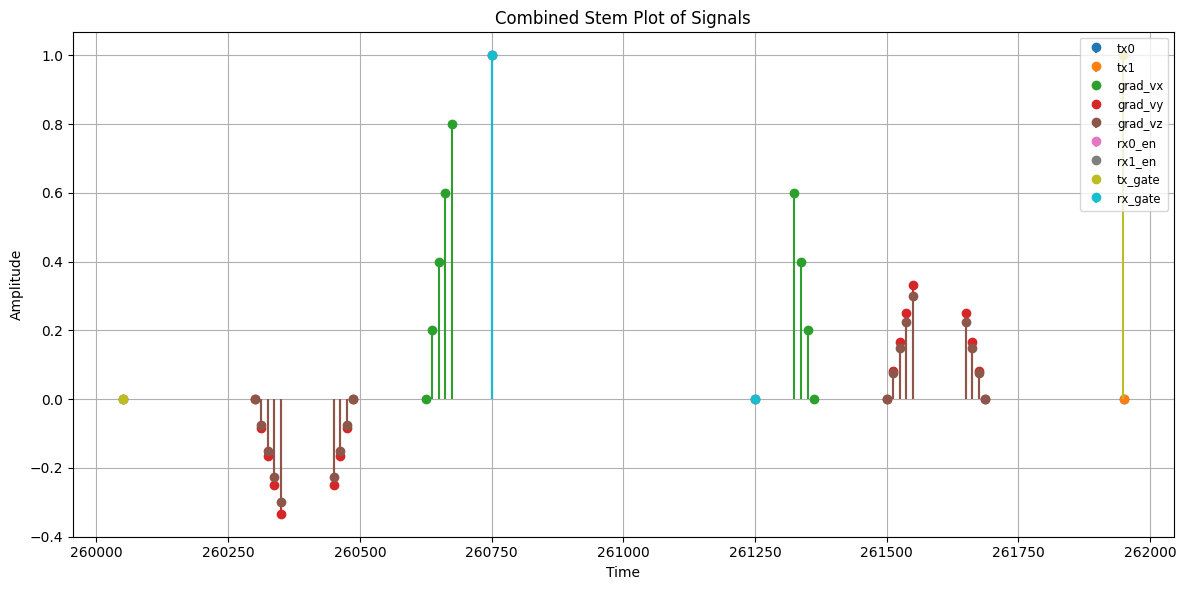

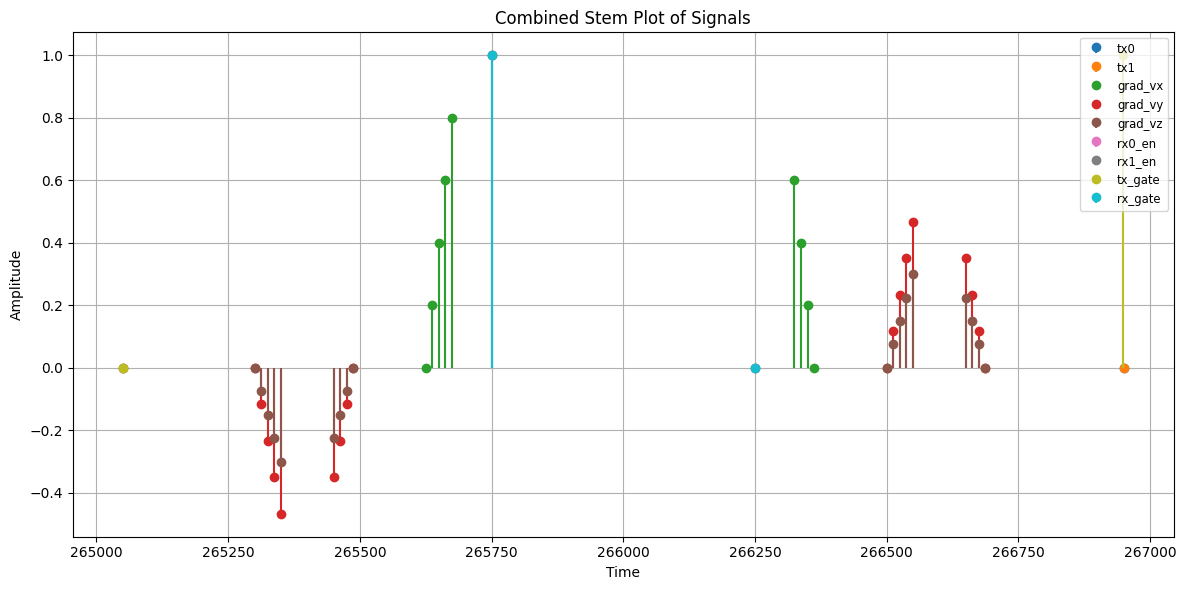

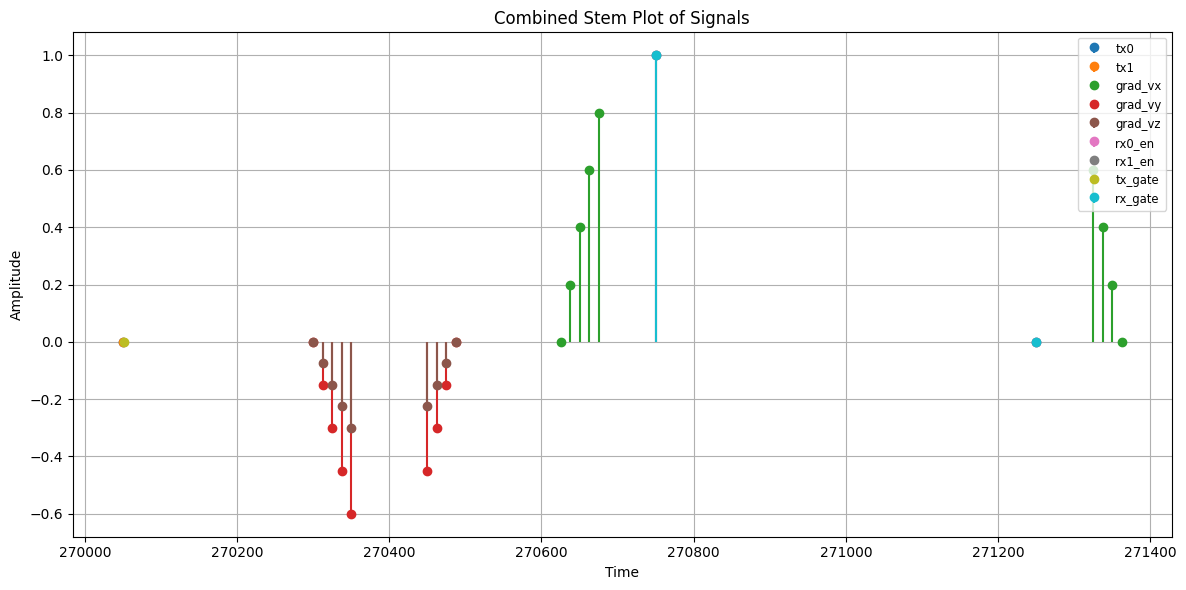

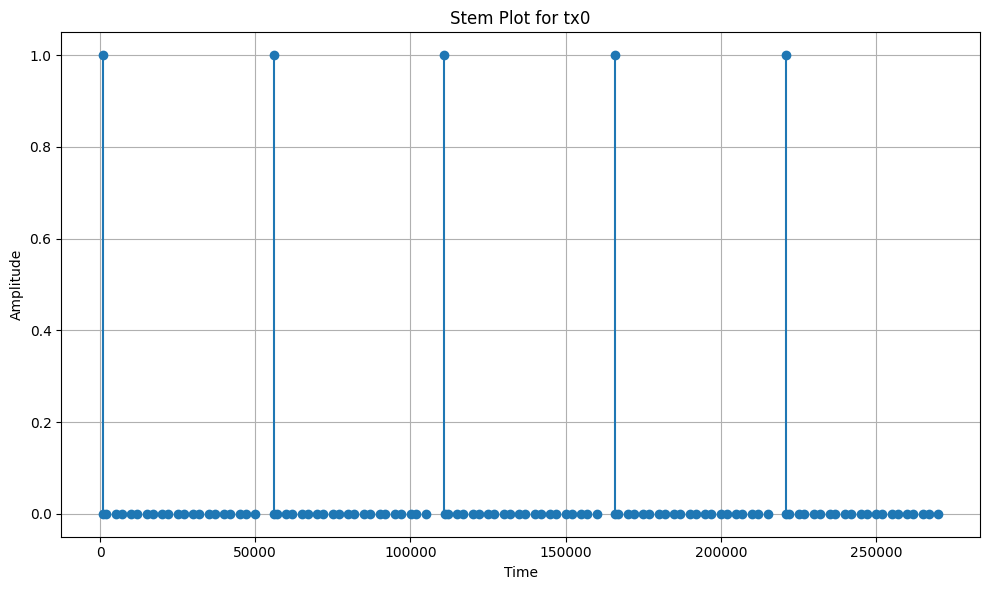

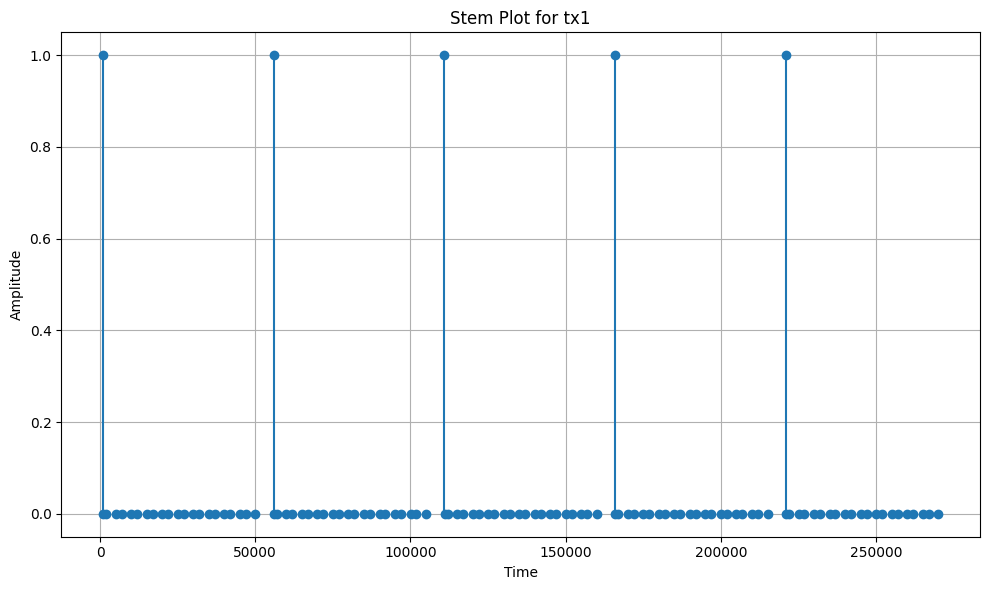

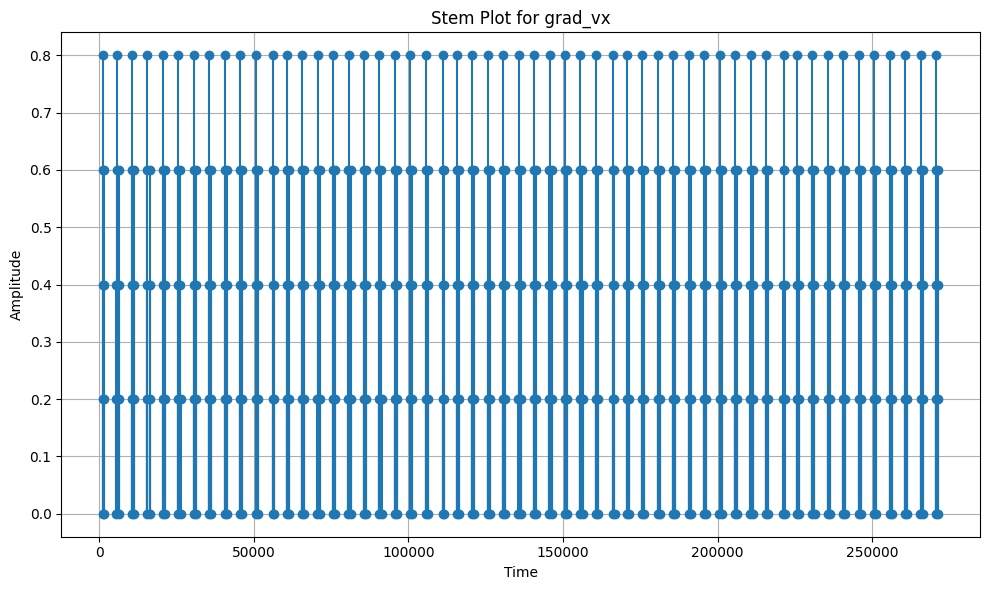

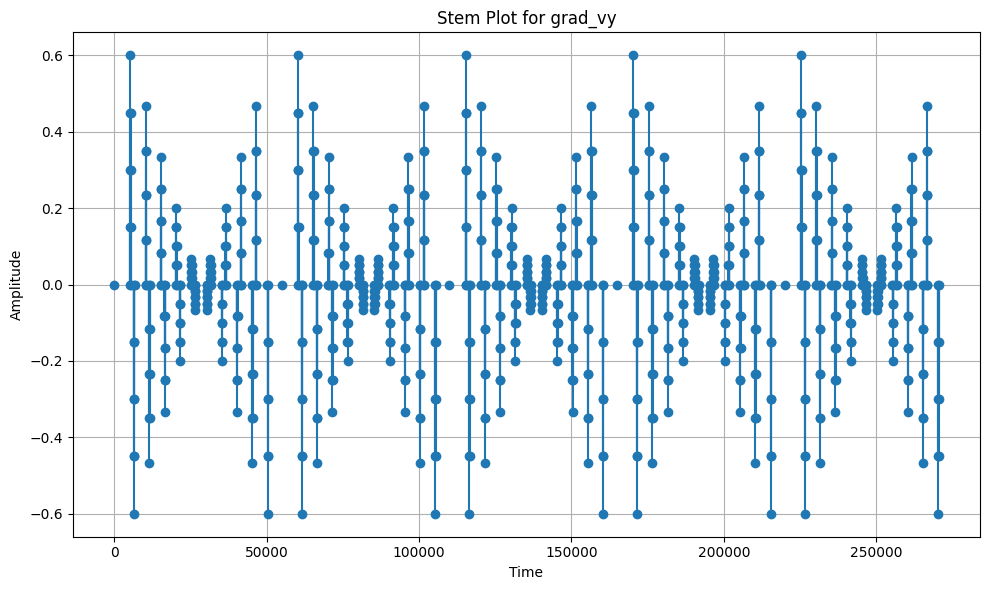

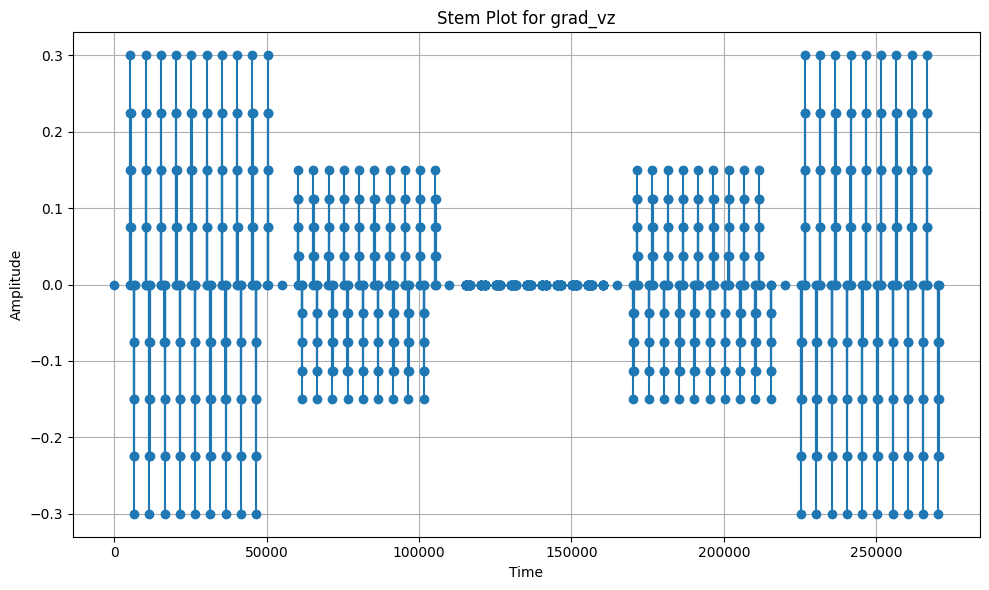

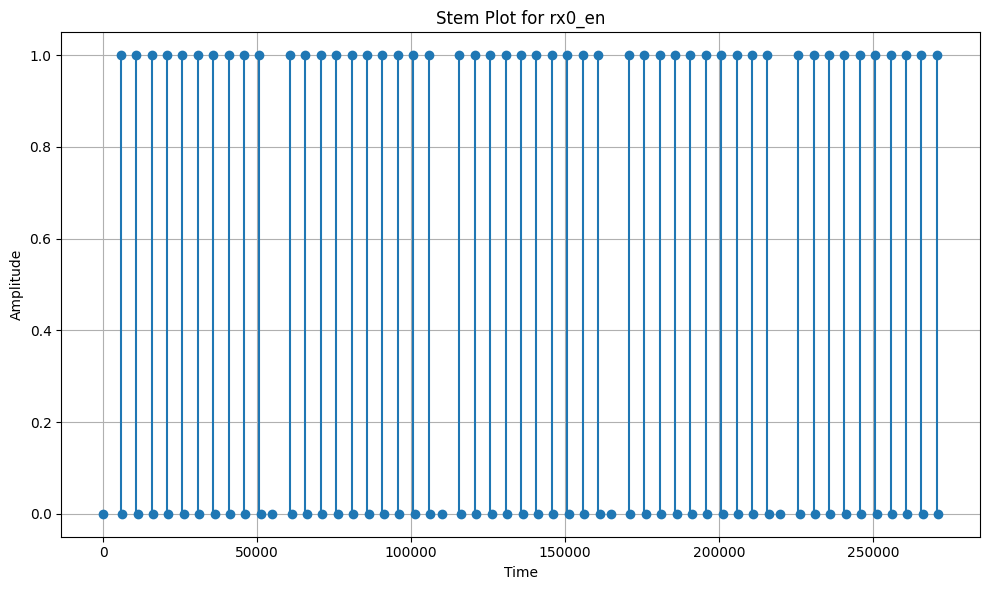

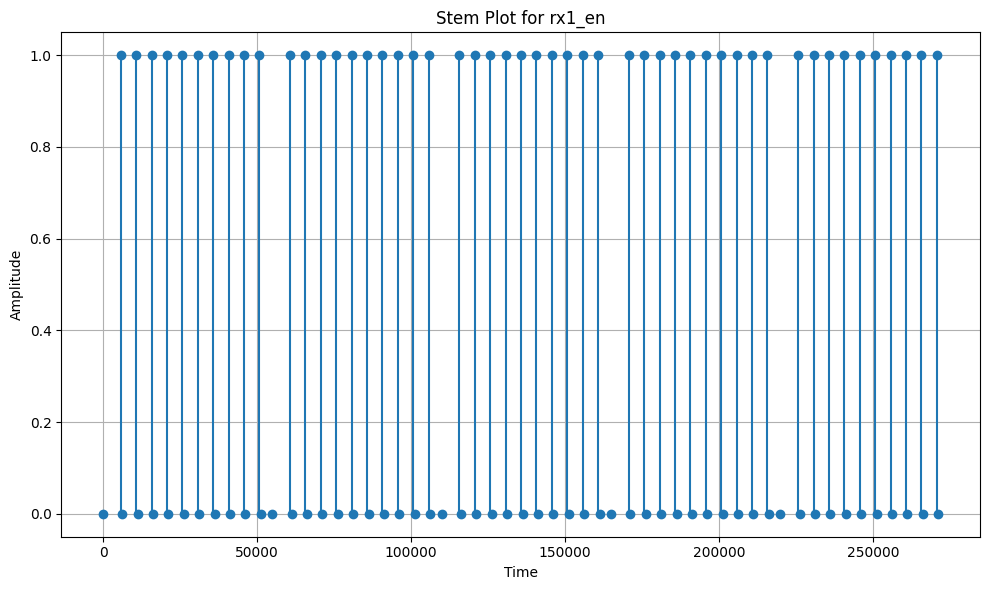

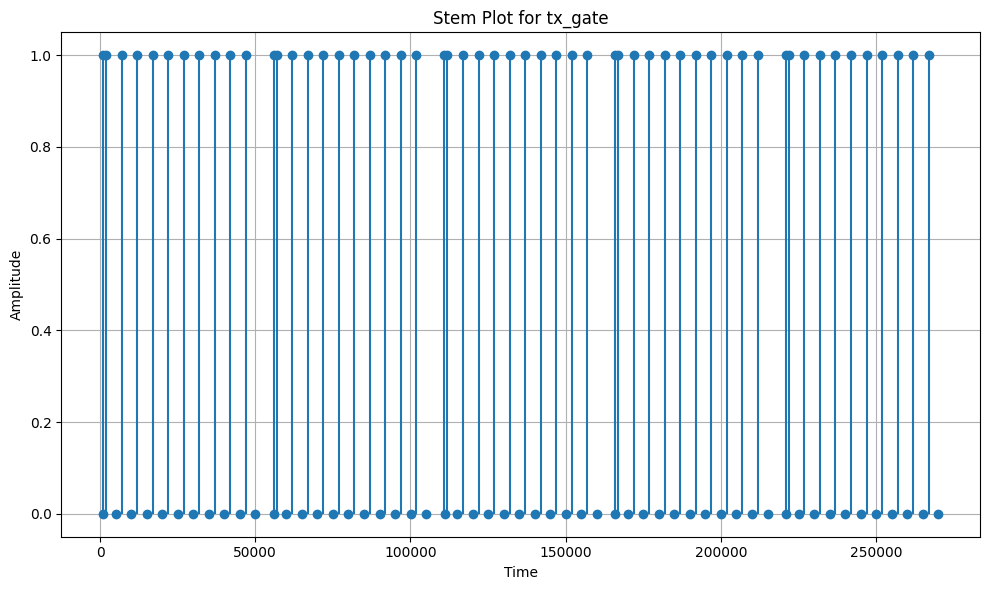

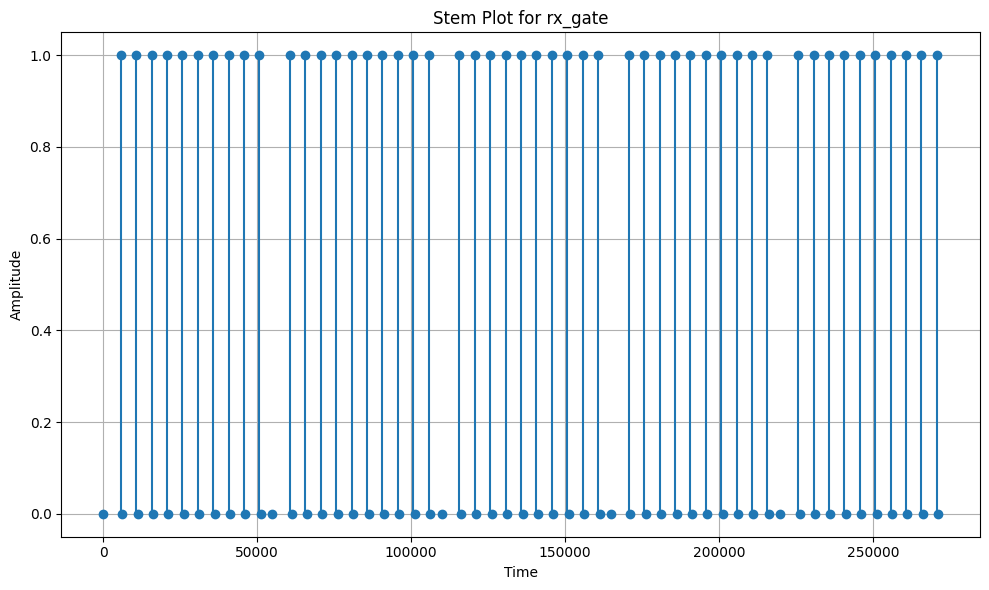

In [68]:
turbo_spin_echo(plot_sequence=True, echos_per_tr=10)